# SM from IRRmodel into WCM, both with PSO on KGE

Here you find both IRRmodel and WCM, separately for separate calibration. \
This is also the main code for plotting and trying things out. \
Keep it clean, keep it working.

# Dependencies, forward and backwards model

In [52]:
# Base
import os
import re
import time
import math
import numpy as np
import pandas as pd
import datetime as dtt

# Analysis
import pyswarms as ps
from scipy import special as sp
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial
from scipy.signal import savgol_filter as sfilter

# Geospatial
# import fiona
import xarray as xr
import hydroeval as he
# import geopandas as gpd
# from maps_original import *

# Graphics
import seaborn as sns
import matplotlib as mplt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pyswarms.utils.plotters import plot_cost_history
from pyswarms.utils.functions.single_obj import sphere

In [53]:
# Ausiliary functions

#-----------------------------------------------------------------------------

def lin_db(x):
    return 10*np.log10(x)

def db_lin(x):
    return 10**(x/10)

def norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def norm_fit(x, a, b):
    """x = data, a<b"""
    return a+(x-np.min(x))*(b-a)/(np.max(x)-np.min(x))

def linear(x,a,b):
    return a+b*x

def bias(obs, sim):
    if len(obs)==len(sim):
        return np.mean(obs-sim)
    else: raise ValueError(
        f'obs and sim must have same first dimension, but have shapes {np.shape(obs)} and {np.shape(sim)}')

In [54]:
def WPSO_6(PAR, inputs, user_in):
    """Irrigation model function for its calibration.
    
    Based on KGE minimization via PSO (pyswarm) optimization.
    Version with 6 parameters to calibrate.
    
    Inputs
    ----------
    - PAR: initial guess values for parameters to calibrate
        PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
    - inputs = [D, P, IRR, EPOT, WWobs]
    
    Return
    -------
    KGE from hydroeval
    
    """

    # User input
    irri = user_in
    
    # Unpack inputs
    #PARs = convert_adim(PAR)
    W_0, W_max, S_fc, S_w, rho_st, Kc = PAR#s
    D, P, IRRobs, EPOT, WWobs = inputs
    
    #S_fc = 0.46 # hardcoded
    #S_w = 0.08  # hardcoded
    W_fc = S_fc*W_max # water content at field capacity
    W_w  = S_w*W_max # water content at wilting point
    
    if irri==True: IRR = [0]*len(D) # daily, water content
    else: IRR = IRRobs
    
    Ks = [0]*len(D) # daily, water stress coefficient
    rho = [0]*len(D) # daily, depletion fraction
    PS = [0]*len(D) # daily, deep percolation
    W = [0]*len(D) # daily, water content
    W[0] = W_0*W_max
    
    for t in [i+1 for i in range(len(D)-1)]:
        rho[t]=rho_st+0.04*(5-Kc*EPOT[t])
        if W[t-1]>=(1-rho[t])*W_fc:
            Ks[t]=1
        elif (W[t-1]>W_w)and(W[t-1]<(1-rho[t])*W_fc):
            Ks[t]=float(W[t-1]-W_w)/((1-rho[t])*(W_fc-W_w))
        else: Ks[t]=0
        
        DOY=D[t].dayofyear
        
        # Irrigation estimate (for summer season only)
        # Irrigation is estimated as the amount of water needed at the day before
        # to take water content up to field capacity
        if np.logical_and(DOY>134,DOY<235): # summer season
            if irri==True:
                if W[t-1]<=(1-rho[t])*W_fc: IRR[t]=W_fc-W[t-1]
        
        # Water balance
        W[t]=W[t-1]+P[t]+IRR[t]-EPOT[t]*Kc*Ks[t]
        
        # Computation of deep percolation (water above field capacity)
        if W[t]>W_fc:
            PS[t]=W[t]-W_fc
            W[t]=W_fc
            
    WW=np.array(W)/W_max
    OUT=he.evaluator(he.kge, WW, WWobs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];
    
    return [KGE,WW,IRR]

#-----------------------------------------------------------------------------

def pso_calib_irri(PAR):
    """Ausiliary function for PSO optimization"""
    global inputs
    global irri
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    #PARs = convert_adim(PAR)
    for i in range(n_particles):
        #KGE,WW,WWobs,IRR = WPSO_6(PARs[i], inputs, irri)        
        KGE,WW,IRR = WPSO_6(PAR[i], inputs, irri)
        err[i] = 1 - KGE
    return err

In [55]:
def WCM(PAR, data_in):
    """Water Cloud Model calibration.
    
    This function simulates backscattering with WCM and returns
    the KGE index to perform its minimization for calibration
    of parameters A,B,C,D of the WCM.
    
    Inputs
    ------
    - PAR: list
        List of initial guesses for the parameters to calibrate.
    - data_in: list
        List of inputs of observables, that must be in the form:
        [SM,LAI,t_deg,obs], being SM = soil moisture,
        LAI = Leaf Area Index, t_deg = angle of observation,
        obs = observed total sigma0
    
    Return
    ------
    KGE between simulated and observed backscattering.
    
    """

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    sig0s_dB = C+D*SM # define bare soil backscatter [dB]
    sig0s = db_lin(sig0s_dB) # from dB to linear scale
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation
    sig0_lin = T2*sig0s+sig0v
    sig0=lin_db(sig0_lin) # from linear scale to dB
        
    OUT=he.evaluator(he.kge, sig0, obs) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [sig0,KGE] # AT THE MOMENT THE OUTPUT IS THE KGE FOR MINIMIZATION OF IT

#-----------------------------------------------------------------------------

def SM_fromWCM(PAR, data_in):
    """Inverted WCM for SM estimation.
    
    """

    A,B,C,D = PAR # parameters
    SM,LAI,t_deg,obs = data_in # input data
    theta = t_deg*np.pi/180. # angle of observation
    
    T2 = np.exp((-2*B*LAI)/np.cos(theta)) # two-way attenuation from the vegetation layer
    sig0v = A*LAI*np.cos(theta)*(1-T2) # define backscatter from the vegetation [lin]
    sig0s_lin = (db_lin(obs)-sig0v)/T2
    SMretr = (lin_db(sig0s_lin)-C)/D
    
    OUT=he.evaluator(he.kge, SMretr, SM) # OUT is kge, r, alpha, beta
    KGE=OUT[0,:];

    return [SMretr,KGE]

#-----------------------------------------------------------------------------

def pso_calib_wcm(PAR):
    global data_in
    global calib
    n_particles = PAR.shape[0]
    err = np.zeros(n_particles)
    for i in range(n_particles):
        if calib=='1': sig0,KGE = WCM(PAR[i], data_in)
        elif calib=='2': SMretr,KGE = SM_fromWCM(PAR[i], data_in)
        else: raise NameError('Please choose one of the options.')
        err[i] = 1-KGE
    return err

#-----------------------------------------------------------------------------

# IRRmodel run

In [56]:
print('Starting IRRmodel...\n'+
      '#-------------------------------------------------------------\n'+
      'Use of satellite-derived SM is provided for comparison, not calibration.\n')

#-----------------------------------------------------------------------------
# Data reading
#-----------------------------------------------------------------------------

# Field data from TEST_SITE
namesite = 'ITALY_BUDRIO'
siteID = '5'
namefig = namesite+'_'+siteID
df = xr.open_dataset(f'IRRmodel\TEST_SITE\TEST_SITE_{namesite}.nc', engine='netcdf4').to_dataframe(); df

# Satellite data (S-1) from Golden tables
golden = pd.read_csv(f'Data\Golden_GEE.csv', delimiter = "\t")

# NDVI (S-2) from Golden tables
df_NDVI = pd.read_csv(f'Data\\NDVI_GEE.csv', delimiter = "\t")

# Budrio field data from Platinum tables
platinum = pd.ExcelFile('Data\Platinum_Budrio.xlsx', engine='openpyxl')
platinum = platinum.parse('2017_1h')
platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
    
filename = f'irr_obs_'

# Dates
D_0 = df.Time_days
D_1 = platinum['Data']
set1 = {x for x in D_0}
set2 = {x for x in D_1}
D = np.sort(np.array([*set1.intersection(set2)]))

Starting IRRmodel...
#-------------------------------------------------------------
Use of satellite-derived SM is provided for comparison, not calibration.



In [57]:
# -----------------------------------------------------------------------------
# User input
#-----------------------------------------------------------------------------

params = []; norma = ''
#opt_time = input('Daily aggregated dataset or hourly? [d/h]')
nrun = int(input('Number of runs? (10 is min to study distribution of parameters.) '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [[]/(any)]')=='' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norma = 1 if input('Which norm? [l1/l2] ')=='l1' else 2
irri = True if input('Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any)')=='' else False

opt_time='d' #hardcoded for now
if opt_time=='d':
    P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
    EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # potential evapotranspiration (measured)
    IRRobs = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values
    Wobs_gap = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].values
    Wobs = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].interpolate(method='linear').values
    WWobs_gap = (Wobs_gap-np.min(Wobs))/(np.max(Wobs)-np.min(Wobs))
    WWobs = norm(Wobs)
elif opt_time=='h':
    P = platinum['Pioggia[mm]'].values
    EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # potential evapotranspiration (measured)
    IRRobs = platinum['Irrigazione[mm]'].values
    Wobs_gap = platinum['SWC[m3/m3]'].values
    Wobs = platinum['SWC[m3/m3]'].interpolate(method='linear').values
    WWobs_gap = (Wobs_gap-np.min(Wobs))/(np.max(Wobs)-np.min(Wobs))
    WWobs = norm(Wobs)

Number of runs? (10 is min to study distribution of parameters.)  1
Number of particles:  10
Number of optimization steps:  100
Verbose? [[]/(any)] 
Global or Local PSO optimizer? [[global]/local]  
Do you want to calibrate irrigation as well as soil moisture? Answer yes will treat irrigation observations as a benchmark for model performance only. [[]/(any) 


In [58]:
len(D)

214

In [59]:
#-----------------------------------------------------------------------------
# Calibration
#-----------------------------------------------------------------------------

print('Starting IRRmodel calibration...\n'+
      '#-------------------------------------------------------------\n')

W_0=      0.1; # [-] water content, initial [m^3/m^3]
W_max=    80;  # [mm] water content, maximum (not normalized)
S_fc=     0.46; # [-] field capacity [m^3/m^3] #********CHECK********#
S_w=      0.08; # [-] wilting point [m^3/m^3] #********CHECK********#
rho_st=   0.2; # [-] crop specific depletion fraction
Kc=       0.4; # [-] crop specific coefficient

#d=d[:1000]; P=P[:1000]; IRRobs=IRRobs[:1000]; EPOT=EPOT[:1000]; Wobs=Wobs[:1000]
inputs = [D, P, IRRobs, EPOT, Wobs]
PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc];

bounds = (
    np.array([  0.1,  0.1, .01, .01,  .1, .3]), # low
    np.array([  0.9, 150, .95, .45,  .7, .5]) # up
)
#bounds = (
#    np.array([  0.5,  50, .80, .01, .1, .3]),# low
#    np.array([  0.9, 120, .95, .45, .7, .5]) # up
#)

#-----------------------------------------------------------------------------
for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR), options=options, bounds=bounds)
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norma }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib_irri, n_step, verbose=verbose)#, **PAR)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Model validation
#-----------------------------------------------------------------------------
KGE,WW,IRR = WPSO_6(PARn, inputs, irri)
print('PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]\n', PARn)
timestr = time.strftime("%y%m%d-%H%M%S")

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

2022-11-29 14:54:00,377 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}


Starting IRRmodel calibration...
#-------------------------------------------------------------



pyswarms.single.global_best: 100%|█████████████|100/100, best_cost=0.25
2022-11-29 14:54:02,735 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.24958148754438592, best pos: [1.44028590e-01 1.46437753e+02 2.74784914e-01 1.03463036e-01
 4.00109645e-01 4.25867752e-01]


PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
 [1.44028590e-01 1.46437753e+02 2.74784914e-01 1.03463036e-01
 4.00109645e-01 4.25867752e-01]


## Standard obsVSsim and simVSsat plots

In [60]:
if input('Do you want to use previously simulated data for standard plots? [y/n]')=='y':
    opt_cost=False
    # WW=np.loadtxt('irr_obs_221123-101848_20_500_glo_.txt')
    # PAR = [W_0, W_max, S_fc, S_w, rho_st, Kc]
    #PARn=[0.33860677, 37.87714981,  0.70439582,  0.32615656,  0.68821702,  0.48270804]
    
    # from IRRI+WCM best fit
    PARn=[0.14828127,42.,.46,.08,0.73557499,0.3691854]

    KGE,WW,IRR = WPSO_6(PARn, inputs, irri)
    timestr = time.strftime("%y%m%d-%H%M%S")

Do you want to use previously simulated data for standard plots? [y/n] y


Save simulated VS observed soil moisture? [[]/(any)] n


RMSE = 0.20236835978059015
NS = 0.2346502221163863
R (WW vs WWobs) = 0.7276018900122943
R_IRR (IRR vs IRRobs)= 0.7582460987578276


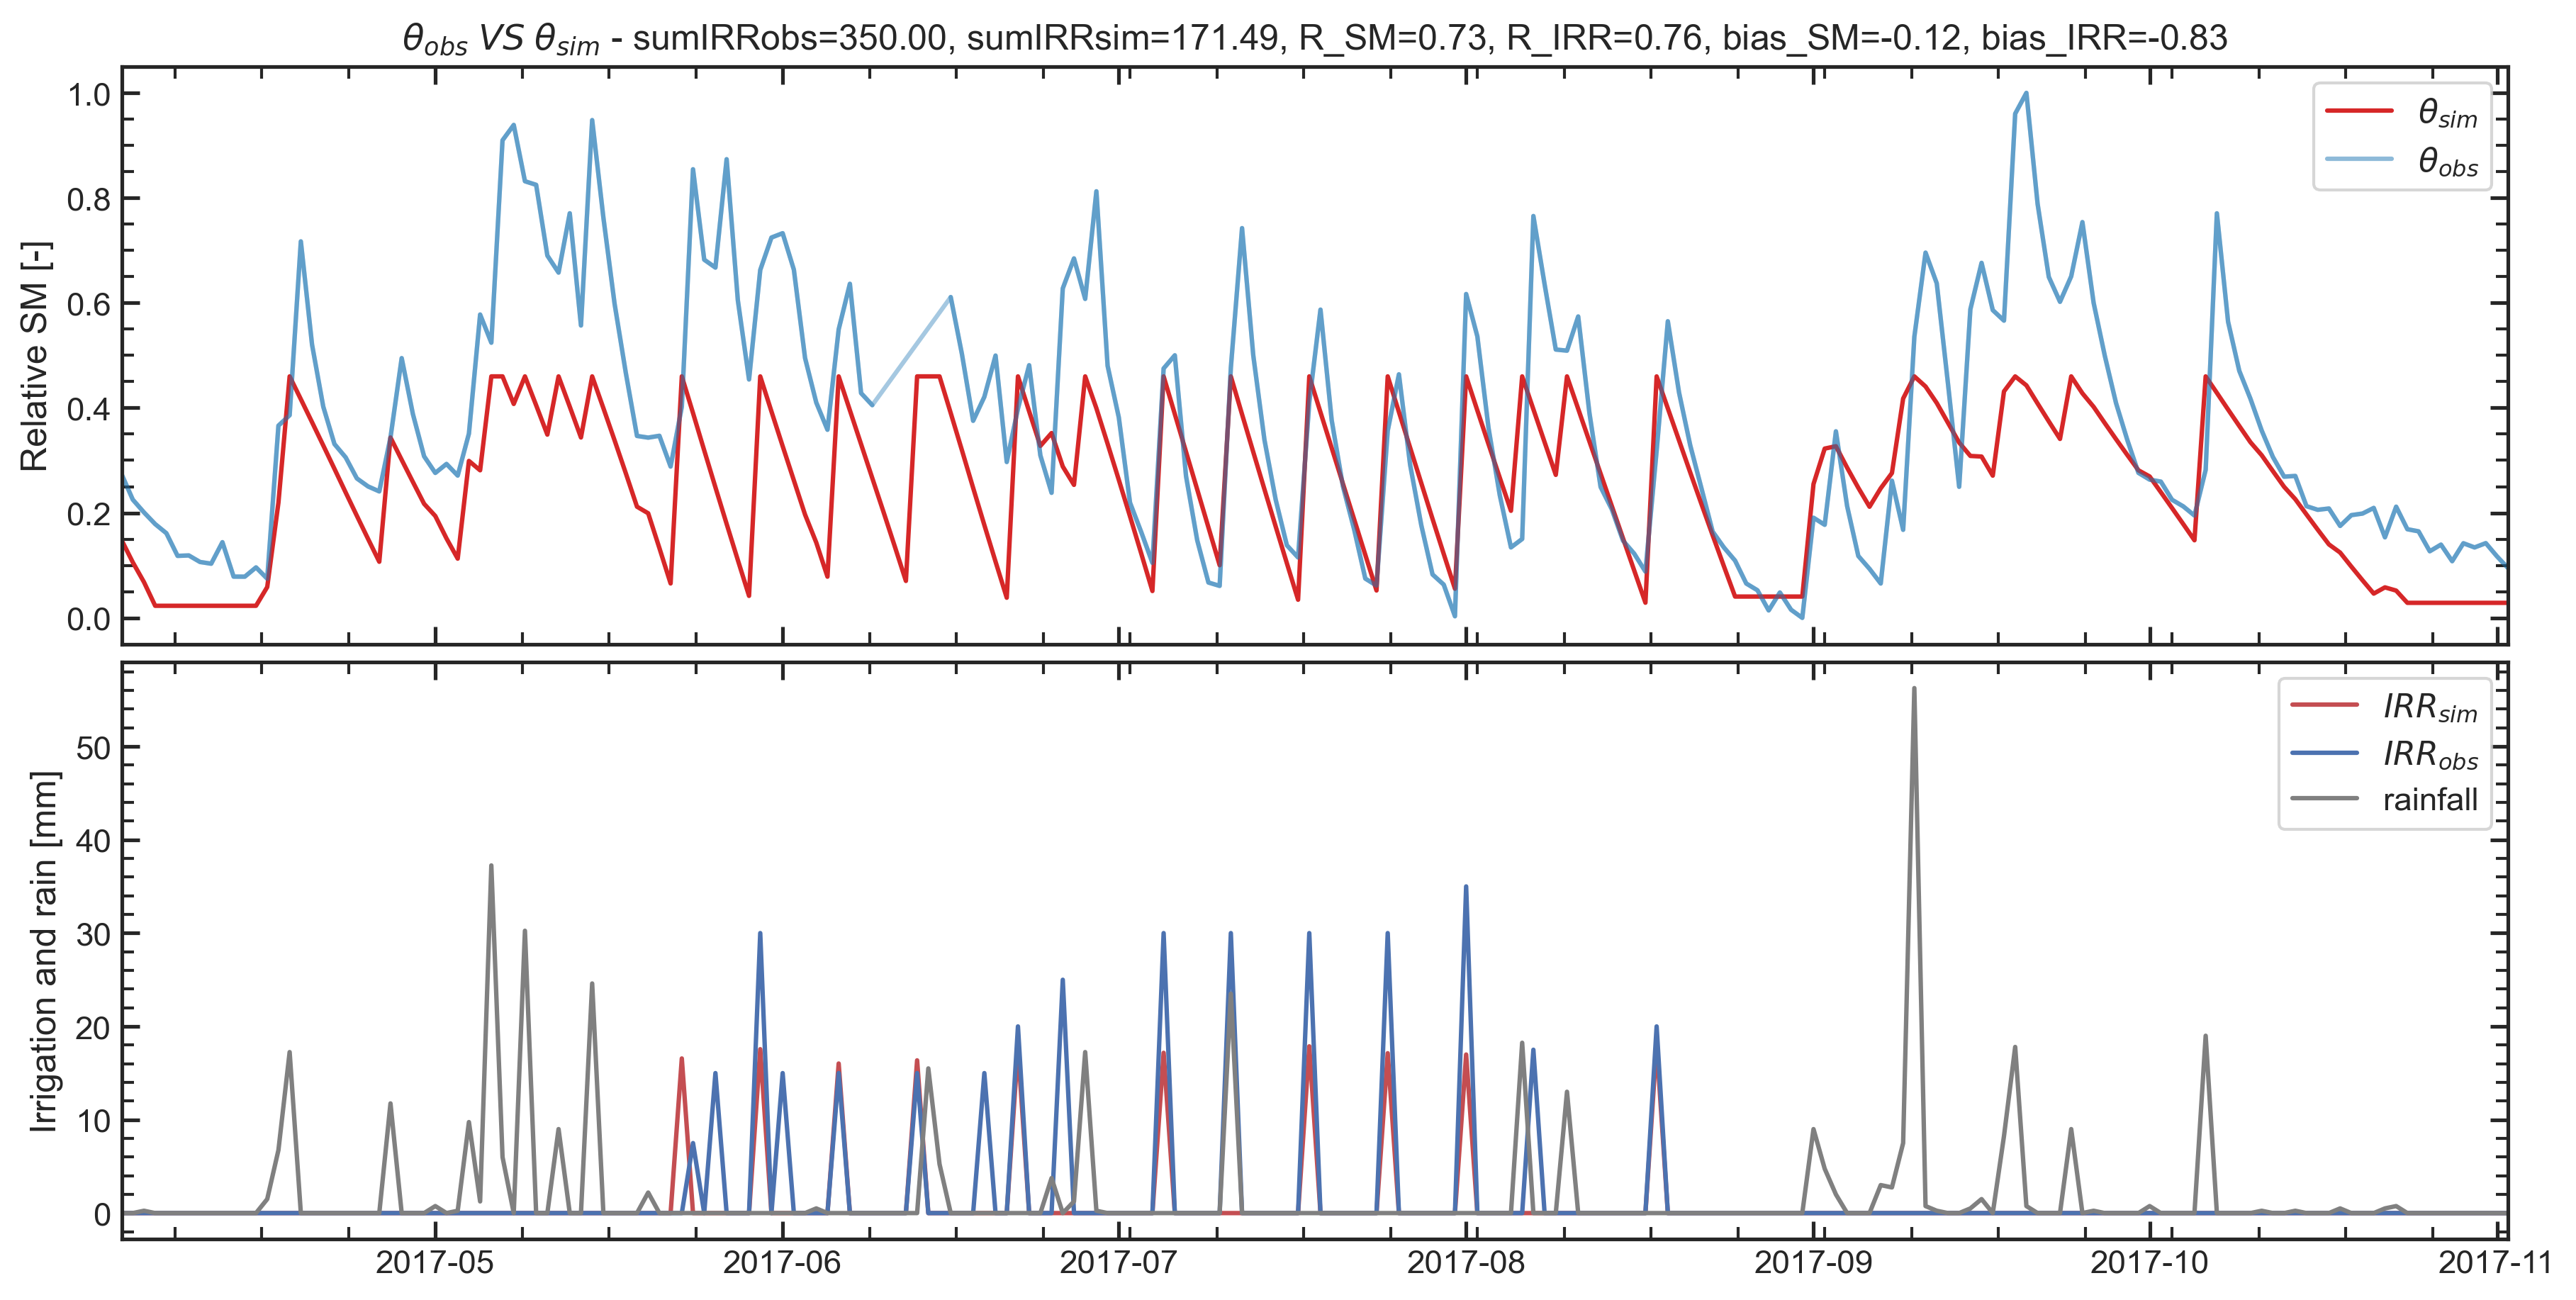

In [61]:
#-----------------------------------------------------------------------------
# Figures
#-----------------------------------------------------------------------------

opt_save_plot = True if input('Save simulated VS observed soil moisture? [[]/(any)]')=='' else False
#-----------------------------------------------------------------------------
# Model performance: RMSE, NS
#-----------------------------------------------------------------------------
RMSE=np.nanmean((WW-WWobs)**2)**0.5; print('RMSE =', RMSE)
NS=1-np.nansum((WW-WWobs)**2)/np.nansum((WWobs-np.nanmean(WWobs))**2); print('NS =', NS)
NS_radQ=1-np.nansum((np.sqrt(WW+0.00001)-np.sqrt(WWobs+0.00001))**2)/np.nansum((np.sqrt(WWobs+0.00001)-np.nanmean(np.sqrt(WWobs+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(WW+0.0001)-np.log(WWobs+0.0001))**2)/np.nansum((np.log(WWobs+0.0001)-np.nanmean(np.log(WWobs+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
WWmatrix = np.array( [ [WW[i], WWobs[i]] for i in range(len(WW)) if not np.isnan(WWobs[i]) ] )
R=np.corrcoef(WWmatrix,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R)
B=bias(np.array([e[0] for e in WWmatrix]), np.array([e[1] for e in WWmatrix]))
IRRmatrix = np.array( [ [IRR[i], IRRobs[i]] for i in range(len(IRR)) if not np.isnan(IRRobs[i]) ] )
R_IRR=np.corrcoef(IRRmatrix,rowvar=False)[0][1]; print('R_IRR (IRR vs IRRobs)=', R_IRR)
B_IRR=bias(np.array([e[0] for e in IRRmatrix]), np.array([e[1] for e in IRRmatrix]))


fig, ax = plt.subplots(2, 1,
                       constrained_layout=True,
                       figsize=(12, 6), sharex=True,
                       dpi=300,)

title=r'$\theta_{obs}\;VS\;\theta_{sim}$ - '+\
    f'sumIRRobs={np.sum(IRRobs):.2f}, '+\
    f'sumIRRsim={np.sum(IRR):.2f}, '+\
    f'R_SM={R:.2f}, R_IRR={R_IRR:.2f}, '+\
    f'bias_SM={B:.2f}, bias_IRR={B_IRR:.2f}'

ax[0].set_xlim(xmin=D[0], xmax=D[len(D)-1])
ax[0].plot(D, WW, c='tab:red', label=r'$\theta_{sim}$')
ax[0].plot(D, WWobs, c='tab:blue', #label=r'$\theta_{obs,interp}$',
               linestyle='-', alpha=.4, zorder=-1)
ax[0].plot(D, WWobs_gap, c='tab:blue', label=r'$\theta_{obs}$', alpha=.5, zorder=2)
ax[0].legend(loc='upper right')
ax[0].set_title(title)
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(D, IRR, c='r', label=r'$IRR_{sim}$')
ax[1].plot(D, IRRobs, c='b', label=r'$IRR_{obs}$')
ax[1].plot(D, P, c='gray', label=r'rainfall')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

name=''
if opt_save_plot==True:
    optim_choice = 'glo' if (optim=='')or(optim=='global') else 'local'
    #name = filename+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    name = filename+'_standard_'+'.png'
    plt.savefig('Plot\\'+name+'.png')
    plt.show()
    plt.close()
    if opt_cost:
        cost_history = optimizer.cost_history
        plot_cost_history(cost_history)
        plt.savefig('Plot\\'+name+'_cost'+'.png')

In [62]:
if input('Do you want to use satellite-derived SM for COMPARISON with simulation? [y/n]')=='y':
    sat = input('Please provide the satellite product you want to use.'
                +'[Options: CCI_active, SMAP, THEIA, RT1, newRT1]')
    print('Be aware that SM data from satellite are NOT interpolated here.\n'+
          'If you want to calibrate IRRmodel with satellite data, refer to original IRRmodel code.')
    opt_plot_sat = input('Save simulated VS satellite-derived soil moisture? [[]/(any)]')
    
    if sat=='newRT1':
        df = pd.read_csv('Data\data_in.csv', delimiter='\t', index_col=0)
        Wsat = df['RT1[-]']#.interpolate(method='linear').values # already normalized
        Wsat_gap=Wsat; WWsat=Wsat; WWsat_gap=WWsat
        d_sat = [pd.Timestamp(df['Date'][i]) for i in range(len(df.Date))]; set1 = {x for x in D}; set2 = {x for x in d_sat}
        d = np.sort(np.array([*set1.intersection(set2)]))
    else:
        start=df.index[(df.Time_days==D[0])].tolist()[0]
        stop=df.index[(df.Time_days==D[-1])].tolist()[0]
        df=df.loc[np.arange(start,stop+1)]
        Wsat_gap = df.set_index('Time_days')[f'SSM_{sat}_{siteID}'].values
        Wsat = df.set_index('Time_days')[f'SSM_{sat}_{siteID}']\
            .interpolate(method='linear',limit_direction='both').values
        WWsat_gap = (Wsat_gap-np.min(Wsat))/(np.max(Wsat)-np.min(Wsat))
        WWsat = norm(Wsat)
        WWsat = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}'].values
        WWsat_interp = df.set_index('Time_days').loc[D][f'SSM_{sat}_{siteID}'].interpolate(method='linear',limit_direction='both').values
        WWsat = (WWsat-np.min(WWsat_interp))/(np.max(WWsat_interp)-np.min(WWsat_interp))
        d=D
   
    filename_plot_sat = f'sim-vs-sat_{sat}_'
    
    #-----------------------------------------------------------------------------
    # Statistics: comparison SIM VS SAT
    #-----------------------------------------------------------------------------
    # Data cleaning
    WW=norm(WW)
    WWmatrix_sat = np.array( [ [WW[i], WWsat[i]] for i in range(np.min([len(WWsat),len(WW)])) if not np.isnan(WWsat[i]) ] )
    WWclean = [e[0] for e in WWmatrix_sat]
    
    # Correlation metrics
    R=np.corrcoef(WWmatrix_sat,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R, '\nR^2 (WW vs WWobs) =', R**2)
    #RMSE=np.nanmean((WW-WWsat)**2)**0.5; print('RMSE =', RMSE)
    B = bias(WWclean,WWsat[~np.isnan(WWsat)]); print('bias =', B)

    #-----------------------------------------------------------------------------
    # Timeseries
    #-----------------------------------------------------------------------------
    title=r'$\theta_{sim}\;VS\;\theta_{sat}$' + f' [{sat}] - R={R:.2f}, RMSE={RMSE:.2f}, bias={B:.2f}'
    
    fig, ax = plt.subplots(2, 1,
                           constrained_layout=True,
                           figsize=(12, 5), sharex=True,
                           dpi=300,)
    
    ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1]); ax[0].set_ylim(-.05,1.05)
    #ax[0].plot(d, WWobs, c='tab:blue', label=r'$\theta_{obs,interp}$', linestyle='--', alpha=.4, zorder=-1)
    ax[0].plot(D, WWobs_gap, c='tab:blue', label=r'$\theta_{obs}$', alpha=.4, zorder=2)
    ax[0].set_ylabel('Relative SM [-]')
    ax[0].set_title(title+r', $R^2$ = '+f' {R**2:.2f}')
    
    ax0=ax[0].twinx()
    ax0.plot(D, WW, c='tab:red', label=r'$\theta_{sim}$')
    ax0.plot(d, Wsat_gap, c='k', label=r'$\theta_{sat}$', marker='o', linestyle='', ms=5, zorder=2)
    ax0.plot(d, Wsat, c='k', #label=r'$\theta_{sat,interp}$',
               marker='', linestyle='-', linewidth=1, ms=0, alpha=1, zorder=3)
    ax0.set_ylabel('SMI [-]')
    ax0.legend(loc='upper right', framealpha=1)
    ax[0].legend(loc='upper left', framealpha=1)
    
    ax[1].bar(D, P, color='tab:gray', label=r'rainfall')
    ax[1].bar(D, IRRobs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
    ax[1].bar(D, IRR, color='tab:red', label=r'$IRR_{sim}$', zorder=3)
    ax[1].legend(loc='upper right')
    ax[1].set_ylabel('Irrigation and rain [mm]')
    
    #name = filename_plot_sat+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    name=filename_plot_sat+'_standard-no-obs_'
    if opt_plot_sat=='': plt.savefig('Plot\\'+name+'.png')
    
    #-----------------------------------------------------------------------------
    # Scatterplot
    #-----------------------------------------------------------------------------
    def linear(x,a,b):
        return a+b*x
    
    plt.figure(figsize=(5,5), dpi=300)
    plt.scatter(WWclean, WWsat[~np.isnan(WWsat)])
    popt, pcov = curve_fit(linear, WWclean, WWsat[~np.isnan(WWsat)])
    plt.plot(np.linspace(-.5,1.5), linear(np.linspace(-.5,1.5),*popt), color='tab:orange')
    
    x=np.linspace(-.05,1.05,100); y=x; plt.plot(x,y,color='k')
    plt.title(title)
    plt.ylabel(r'$\theta_{sim}$ [-]'); plt.xlabel(r'$\theta_{sat}$'+f' [{sat}] [-]')
    plt.xlim(-.05,1.05); plt.ylim(-.05,1.05)
    t = plt.text(0.3, 0.75,
                 f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
                 r'$R^2$'+f'={R**2:.2f}',
                 ha="center", va="center", size=15,
                 bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
    #name = filename_plot_sat+'_scat_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
    name=filename_plot_sat+'_scat_standard_'
    if opt_plot_sat=='': plt.savefig('Plot\\'+name+'.png')

Do you want to use satellite-derived SM for COMPARISON with simulation? [y/n] n


## RT1 old VS new

In [80]:
# rt1 old VS new

dfrt1 = pd.read_csv('Data\data_in.csv', delimiter='\t', index_col=0)
rt1 = dfrt1['RT1[-]'].interpolate(method='linear').values # already normalized
d_sat = [pd.Timestamp(dfrt1['Date'][i]) for i in range(len(dfrt1.Date))];
# set1 = {x for x in D}; set2 = {x for x in d_sat}; d = np.sort(np.array([*set1.intersection(set2)]))

sat='RT1'
start=df.index[(df.Time_days==d[0])].tolist()[0]
stop=df.index[(df.Time_days==d[-1])].tolist()[0]
df=df.loc[np.arange(start,stop+1)]
Wsat_gap = df.set_index('Time_days')[f'SSM_{sat}_{siteID}'].values
Wsat = df.set_index('Time_days')[f'SSM_{sat}_{siteID}']\
    .interpolate(method='linear',limit_direction='both').values
WWsat_gap = (Wsat_gap-np.min(Wsat))/(np.max(Wsat)-np.min(Wsat))
WWsat = norm(Wsat)
WWsat = df.set_index('Time_days').loc[d][f'SSM_{sat}_{siteID}'].values
WWsat_interp = df.set_index('Time_days').loc[d][f'SSM_{sat}_{siteID}'].interpolate(method='linear',limit_direction='both').values
WWsat = (WWsat-np.min(WWsat_interp))/(np.max(WWsat_interp)-np.min(WWsat_interp))
   
filename_plot_sat = f'sim-vs-sat_{sat}_'

In [81]:
#-----------------------------------------------------------------------------
# Statistics: comparison SIM VS SAT
#-----------------------------------------------------------------------------
# Data cleaning
WW=rt1
WWmatrix_sat = np.array( [ [WW[i], WWsat[i]] for i in range(np.min([len(WWsat),len(WW)])) if not np.isnan(WWsat[i]) ] )
WWclean = [e[0] for e in WWmatrix_sat]

# Correlation metrics
R=np.corrcoef(WWmatrix_sat,rowvar=False)[0][1]; print('R (WW vs WWobs) =', R, '\nR^2 (WW vs WWobs) =', R**2)
#RMSE=np.nanmean((WW-WWsat)**2)**0.5; print('RMSE =', RMSE)
B = bias(WWclean,WWsat[~np.isnan(WWsat)]); print('bias =', B)

R (WW vs WWobs) = 0.9282158920941475 
R^2 (WW vs WWobs) = 0.861584742336134
bias = -0.02584945054945055


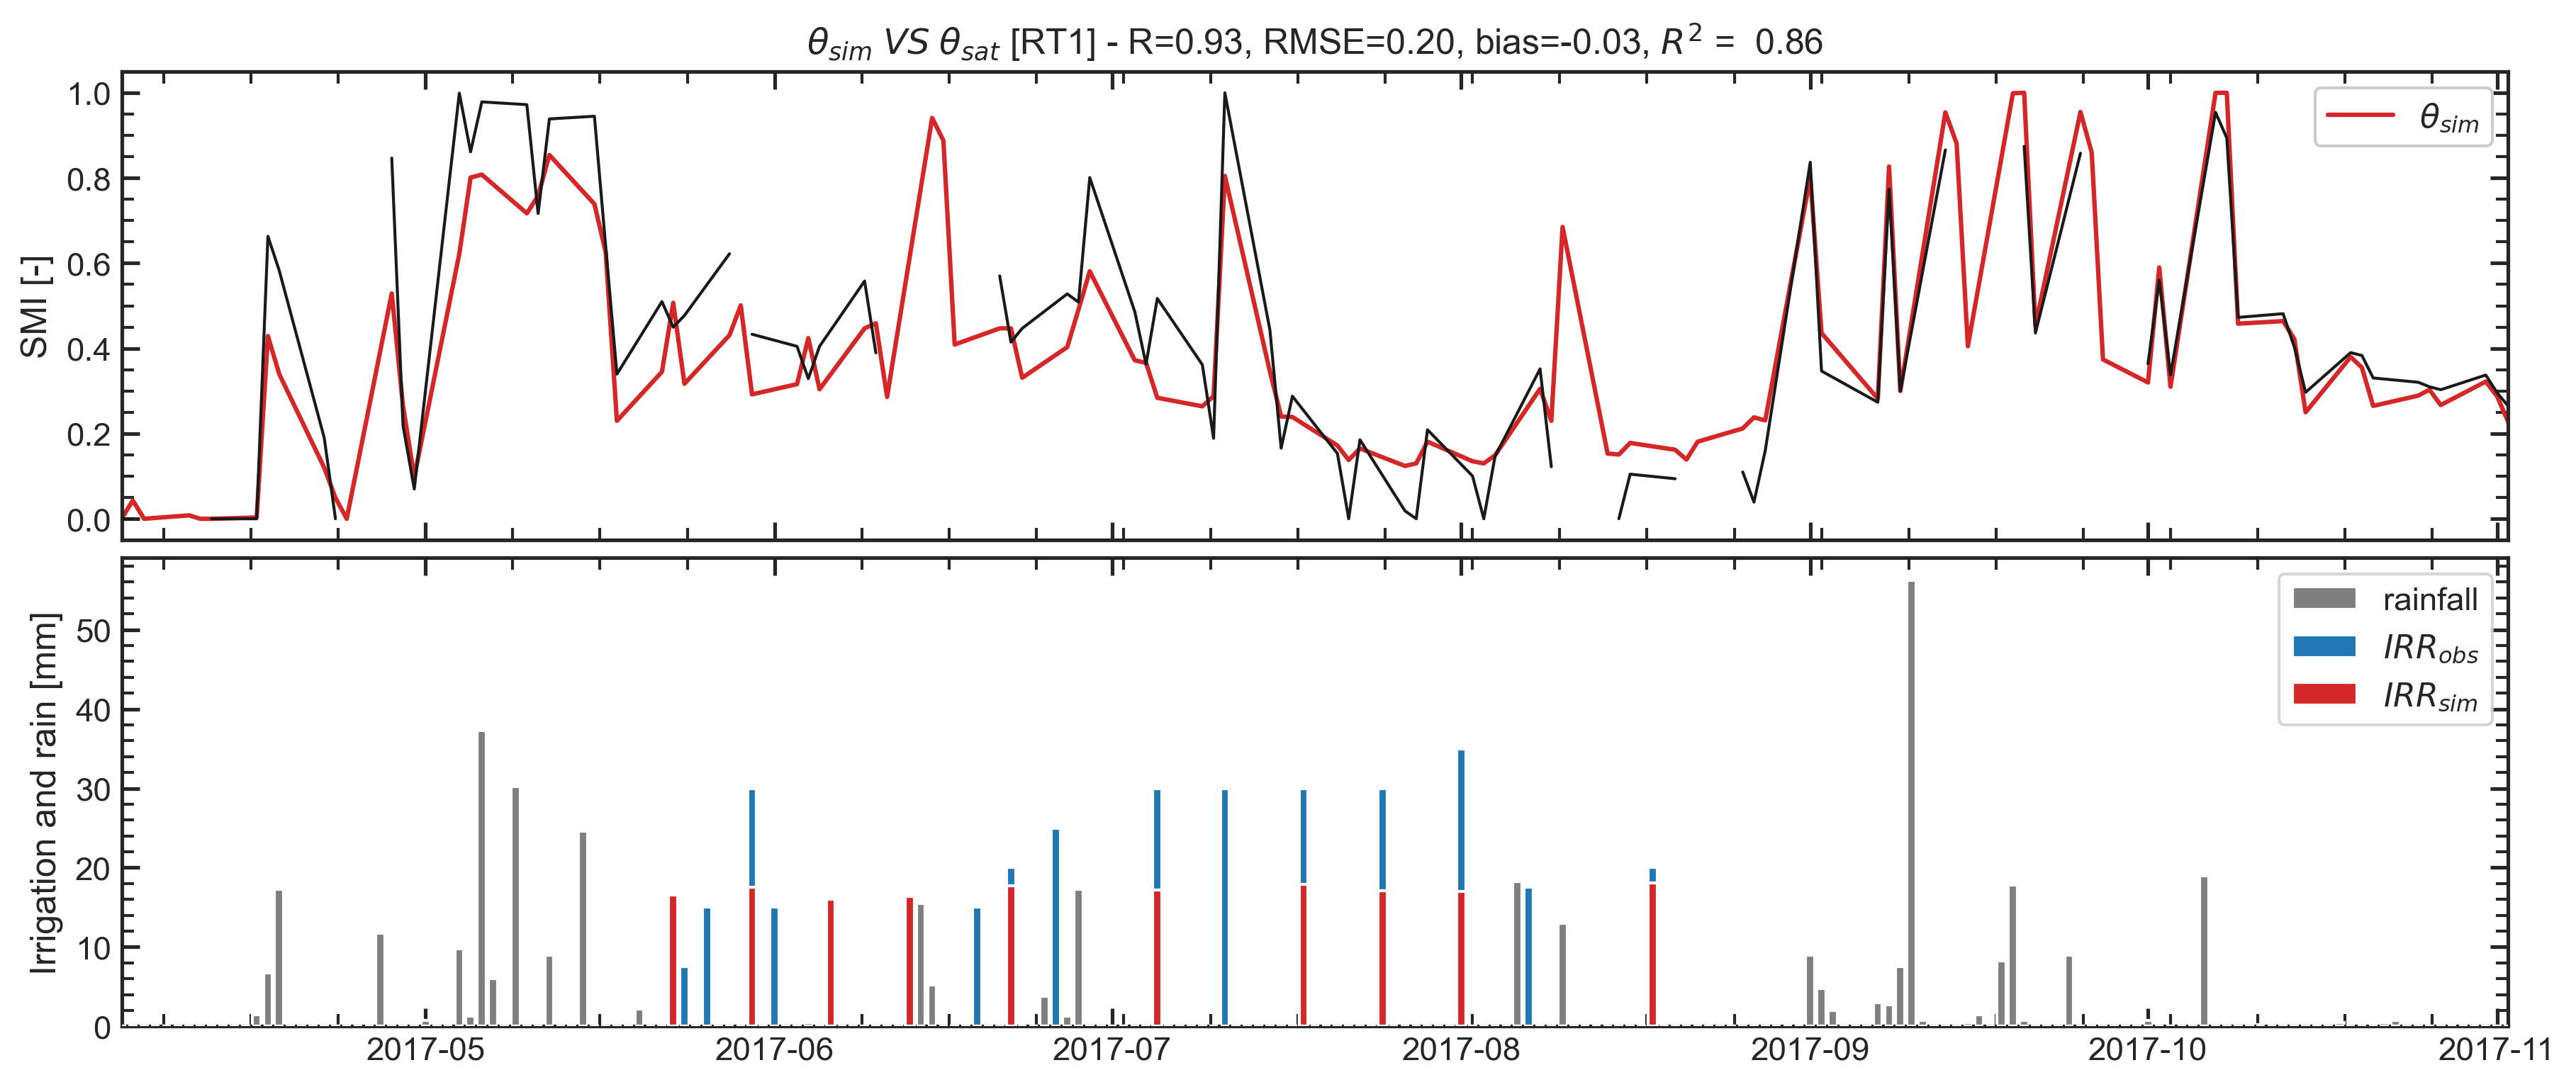

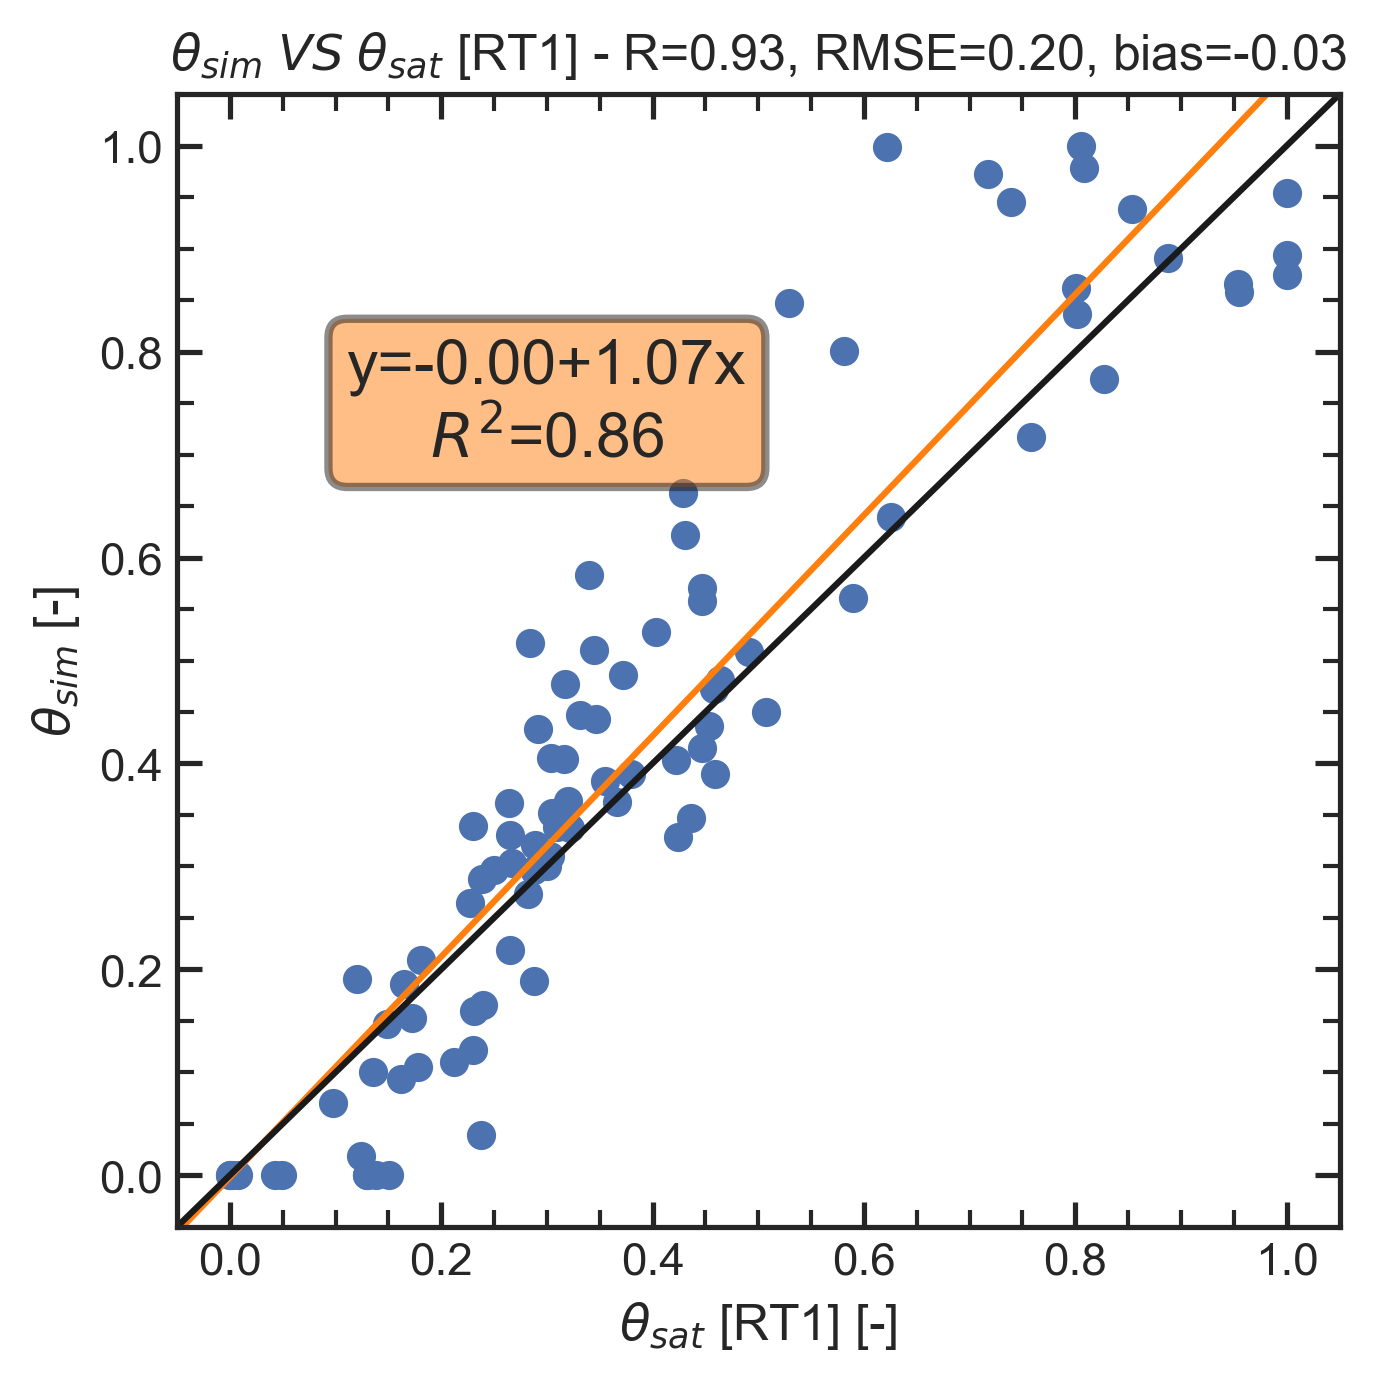

In [84]:
#-----------------------------------------------------------------------------
# Timeseries
#-----------------------------------------------------------------------------
title=r'$\theta_{sim}\;VS\;\theta_{sat}$' + f' [{sat}] - R={R:.2f}, RMSE={RMSE:.2f}, bias={B:.2f}'

fig, ax = plt.subplots(2, 1,
                       constrained_layout=True,
                       figsize=(12, 5), sharex=True,
                       dpi=300,)

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1]); ax[0].set_ylim(-.05,1.05)
ax[0].set_ylabel('Relative SM [-]')
ax[0].set_title(title+r', $R^2$ = '+f' {R**2:.2f}')
ax[0].plot(d, WW, c='tab:red', label=r'$\theta_{sim}$')
ax[0].plot(d, WWsat, c='k', #label=r'$\theta_{sat,interp}$',
           marker='o', linestyle='-', linewidth=1, ms=0, alpha=1, zorder=3)
ax[0].set_ylabel('SMI [-]')
ax[0].legend(loc='upper right', framealpha=1)

ax[1].bar(D, P, color='tab:gray', label=r'rainfall')
ax[1].bar(D, IRRobs, color='tab:blue', label=r'$IRR_{obs}$', zorder=2)
ax[1].bar(D, IRR, color='tab:red', label=r'$IRR_{sim}$', zorder=3)
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Irrigation and rain [mm]')

#name = filename_plot_sat+'_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
name=filename_plot_sat+'_standard-no-obs_'
if opt_plot_sat=='': plt.savefig('Plot\\'+name+'.png')

#-----------------------------------------------------------------------------
# Scatterplot
#-----------------------------------------------------------------------------
def linear(x,a,b):
    return a+b*x

plt.figure(figsize=(5,5), dpi=300)
plt.scatter(WWclean, WWsat[~np.isnan(WWsat)])
popt, pcov = curve_fit(linear, WWclean, WWsat[~np.isnan(WWsat)])
plt.plot(np.linspace(-.5,1.5), linear(np.linspace(-.5,1.5),*popt), color='tab:orange')

x=np.linspace(-.05,1.05,100); y=x; plt.plot(x,y,color='k')
plt.title(title)
plt.ylabel(r'$\theta_{sim}$ [-]'); plt.xlabel(r'$\theta_{sat}$'+f' [{sat}] [-]')
plt.xlim(-.05,1.05); plt.ylim(-.05,1.05)
t = plt.text(0.3, 0.75,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))
#name = filename_plot_sat+'_scat_'+timestr+f'_{n_particles}_{n_step}_{optim_choice}_{norma}'
name=filename_plot_sat+'_scat_standard_'
if opt_plot_sat=='': plt.savefig('Plot\\'+name+'.png')

# WCM

In [13]:
#-----------------------------------------------------------------------------
# Init
#-----------------------------------------------------------------------------
print('Starting WCM run...\n'+
      '#-------------------------------------------------------------')

# Getting data
df = pd.read_csv('Data\data_in.csv', delimiter='\t', index_col=0); # df
df_NDVI = pd.read_csv(f'Data\\NDVI_GEE.csv', delimiter = "\t")
df_NDVI.Datetime = df_NDVI.Datetime.apply(lambda x:pd.Timestamp(x))

# Temporal, spatial
# d = df['Date'].apply(lambda x : np.datetime64(x)).values
d_sat = [pd.Timestamp(df['Date'][i]) for i in range(len(df.Date))]
set1 = {x for x in D}; set2 = {x for x in d_sat}
d = np.sort(np.array([*set1.intersection(set2)]))

# Soil moisture
SM_unnorm = df['SWC[m3/m3]'].interpolate(method='linear').values 
SM_norm = norm(df['SWC[m3/m3]'].interpolate(method='linear').values) # normalized
SM_gap = (df['SWC[m3/m3]'].values-np.min(SM_unnorm))/(np.max(SM_unnorm)-np.min(SM_unnorm)) # normalized
rt1 = df['RT1[-]']#.interpolate(method='linear').values # already normalized

col1 = D; col2 = WW; matrix=[[col1[i],col2[i]] for i in range(np.min([len(col1),len(col2)]))]
SM_irri = pd.DataFrame(matrix).set_index(0).loc[d][1].values


# Backscattering
t_deg = df['Angle[°]'].values
obs = df['VV_norm[dB]'].values#.interpolate(method='linear').values
obs_VH = df['VH_norm[dB]'].values#.interpolate(method='linear').values

# Vegetation indexes
LAI = df['LAI[m2/m2]'].values
cr = (db_lin(obs_VH)/db_lin(obs))
NDVI = df_NDVI.set_index('Datetime').loc[d]['NDVI'].values

#-----------------------------------------------------------------------------
# User input
#-----------------------------------------------------------------------------

index = input('Please provide name of vegetation index to use as input. [Options: LAI, cr, vh, NDVI]')
if index=='LAI': veg=LAI; label_veg='LAI[-]'
elif index=='NDVI': veg=NDVI; label_veg='NDVI[-]'
elif index=='cr': veg=cr; label_veg=r'$\sigma^0$ cross ratio VH/VV [-]'
elif index=='vh': veg=db_lin(obs_VH); label_veg=r'$\sigma^0$ [VH] [dB]'
else: raise NameError('Please select one of the available options')

soilm = input('Please provide name of soil moisture product to use as input. [Options: situ, irri]')
if soilm=='situ': SM=SM_norm
elif soilm=='irri': SM=SM_irri
else: raise NameError('Please select one of the available options')

calib = input('Calibrate on sigma0 or sm? [1 for sigma0, 2 for sm]')

#-----------------------------------------------------------------------------
# NOTE: irrigation and precipitation from Golden_GEE may not be plotted
# since the database only takes hourly values consistent with satellite obs
# and retrieving daily sums is impossible from that database
# refer to Platinum_Budrio to retrieve daily, code is below

# # Budrio field data from Platinum tables
# platinum = pd.ExcelFile('Platinum_Budrio.xlsx', engine='openpyxl')
# platinum = platinum.parse('2017_1h')
# platinum['Ora_1'] = pd.to_datetime(platinum['Ora'].astype('str')).apply(lambda x: x.time())
# platinum['Data_1'] = pd.to_datetime(platinum['Data'].astype('str')).apply(lambda x: x.date())
# platinum['Date'] = platinum.apply(lambda r : dtt.datetime.combine(r['Data_1'],r['Ora_1']),1)
# platinum = platinum.drop(['ID', 'Data_1', 'Ora_1', '214Pb[cps]'],axis=1)
# 
# # Other inputs
# P = platinum.resample('1D',on='Date').sum()['Pioggia[mm]'].values
# EPOT = df.set_index('Time_days').loc[D][f'PET_{siteID}'].values # evapotranspiration (measured)
# IRRobs = platinum.resample('1D',on='Date').sum()['Irrigazione[mm]'].values
# Wobs = platinum.resample('1D',on='Date').mean()['SWC[m3/m3]'].interpolate(method='linear').values
#-----------------------------------------------------------------------------

Starting WCM run...
#-------------------------------------------------------------


Please provide name of vegetation index to use as input. [Options: LAI, cr, vh, NDVI] NDVI
Please provide name of soil moisture product to use as input. [Options: situ, irri] situ
Calibrate on sigma0 or sm? [1 for sigma0, 2 for sm] 1


In [14]:
#-----------------------------------------------------------------------------
# Calibration
#-----------------------------------------------------------------------------

data_in=[SM,veg,t_deg,obs]
PAR=[0.1,0.1,-10,3] # [A,B,C,D] and some guess values
bounds = (np.array([0.1, 0.1, -20, 0]), # min
          np.array([0.5, 1,-5,10])) # max
# from Modanesi_2022

#-----------------------------------------------------------------------------
# Build an array of parameters to evaluate their distribution
params=[]
nrun = int(input('Number of runs: '))
n_particles = int(input('Number of particles: '))
n_step = int(input('Number of optimization steps: '))
verbose = True if input('Verbose? [t/f]')=='t' else False
optim = input('Global or Local PSO optimizer? [[global]/local] ')
if optim=='local': norm = 1 if input('Which norm? [l1/l2] ')=='l1' else 2

for i in range(int(nrun)):
    if (optim=='global')or(optim==''):
        # options = {'c1': 0.5, 'c2': 0.9, 'w': 0.6}
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
        optimizer = ps.single.GlobalBestPSO(n_particles=int(n_particles), dimensions=len(PAR), options=options, bounds=bounds)
    elif optim=='local':
        options = {'c1': 0.4, 'c2': 0.4, 'w': 0.8, 'k':int(0.1*n_particles), 'p':norm }
        optimizer = ps.single.LocalBestPSO(n_particles=n_particles, dimensions=len(PAR), options=options, bounds=bounds)
    else: raise NameError('Please provide an accepted option.')
    cost, PARn = optimizer.optimize(pso_calib_wcm, n_step, verbose=verbose)
    params.append(PARn)
    i+=1

#-----------------------------------------------------------------------------
# Study distribution of parameters
#-----------------------------------------------------------------------------
matrix = np.array([ np.array([ params[i][j] for i in range(len(params)) ])
        for j in range(len(params[0])) ])

if (int(nrun)>9)and(input('Plot parameters distributions? [y/n]')=='y'):
    for i in range(len(matrix)):
        plt.hist(matrix[i])
        plt.show()

#-----------------------------------------------------------------------------
# Forward model
#-----------------------------------------------------------------------------
sigma0_retr,KGE = WCM(PARn, data_in)
print('Params = [A, B, C, D]\n', PARn)

#-----------------------------------------------------------------------------
# Inverse model
#-----------------------------------------------------------------------------
data_val = [SM,veg,t_deg,obs]
SM_retr,KGE=SM_fromWCM(PARn, data_val);

Number of runs:  1
Number of particles:  10
Number of optimization steps:  100
Verbose? [t/f] t
Global or Local PSO optimizer? [[global]/local]  


2022-11-29 12:55:30,201 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.4, 'c2': 0.4, 'w': 0.8}
pyswarms.single.global_best: 100%|████████████|100/100, best_cost=0.404
2022-11-29 12:55:31,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.40386587948692343, best pos: [  0.38948686   0.62046995 -13.37374729   9.29342101]


Params = [A, B, C, D]
 [  0.38948686   0.62046995 -13.37374729   9.29342101]


C:\Users\MARTINA\AppData\Local\Temp\ipykernel_872\348867541.py:6: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(x)


## Plots

### Inputs plot

Plot inputs? [y/n] y
Save inputs fig? [[]/(any)] n


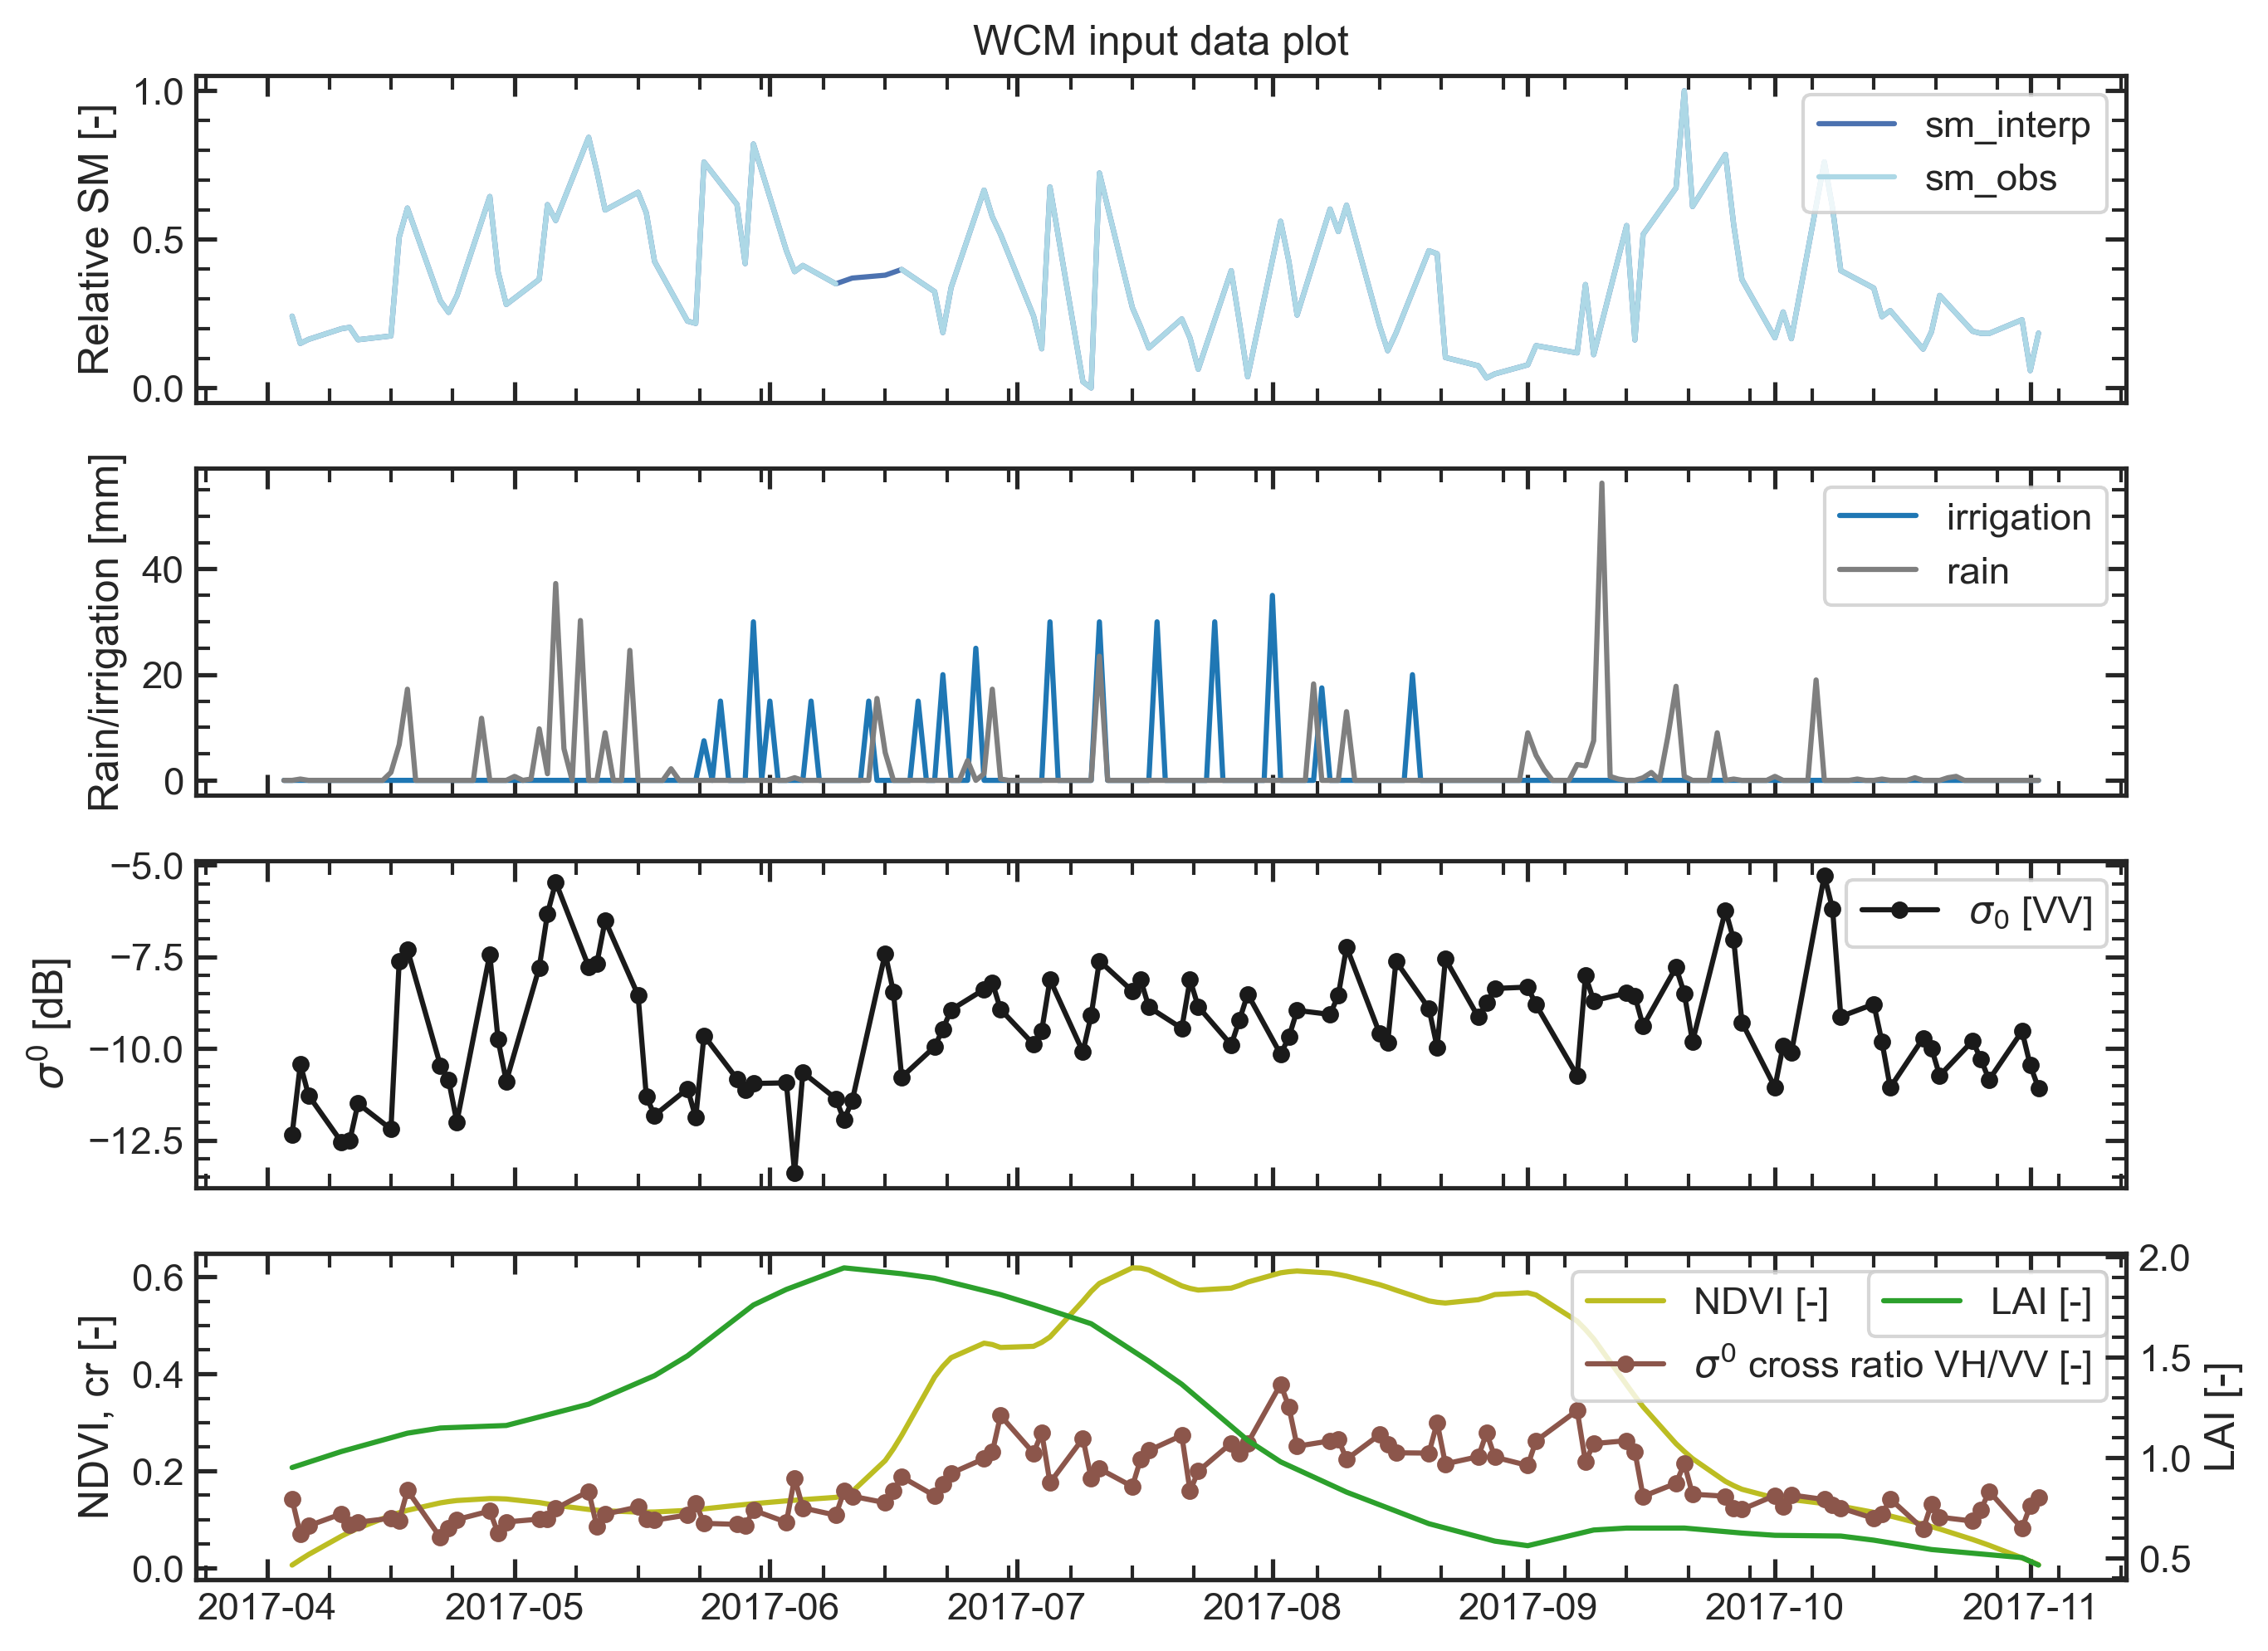

In [15]:
#-----------------------------------------------------------------------------
# Figures
#-----------------------------------------------------------------------------
    
#-----------------------------------------------------------------------------
# Inputs plot
#-----------------------------------------------------------------------------

if input('Plot inputs? [y/n]')=='y':

    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10,8),dpi=300)

    ax[0].set_title('WCM input data plot')

    ax[0].plot(d, SM_norm, color='b', label='sm_interp')
    ax[0].plot(d, SM_gap, color='lightblue', label='sm_obs')
    #ax[0].plot(d, SM_irri, color='red', label='sm_irri')
    # ax[0].plot(d, rt1, color='yellow', label='sm_rt1')
    ax[0].legend(loc='upper right')
    ax[0].set_ylabel('Relative SM [-]')
    
    ax[1].plot(D, IRRobs, label='irrigation', color='tab:blue')
    ax[1].plot(D, P, label='rain', color='tab:gray')
    ax[1].set_ylabel('Rain/irrigation [mm]')
    ax[1].legend(loc='upper right')
    
    ax[2].plot(d, obs, label=r'$\sigma_0$ [VV]', marker='o', markersize=4, color='k')
    ax[2].legend(loc='upper right')
    ax[2].set_ylabel('$\sigma^0$ [dB]')
    
    ax[3].plot(d, NDVI, label='NDVI [-]', color='tab:olive')
    ax[3].plot(d, cr, label=r'$\sigma^0$ cross ratio VH/VV [-]',
               marker='o', markersize=4,
               color='tab:brown') # normalized for visualization reasons only
    ax[3].legend(loc='upper right')
    ax[3].set_ylabel('NDVI, cr [-]')
    
    ax4=ax[3].twinx()
    ax4.plot(d, LAI, label='LAI [-]', color='tab:green')
    ax4.set_ylabel('LAI [-]')
    ax4.legend(loc='best')
    
    # NOTE: irrigation and precipitation from Golden_GEE may not be plotted
    # since the database only takes hourly values consistent with satellite obs 
    
    if input('Save inputs fig? [[]/(any)]')=='':
        plt.savefig('WCM_plot_inputs.png')

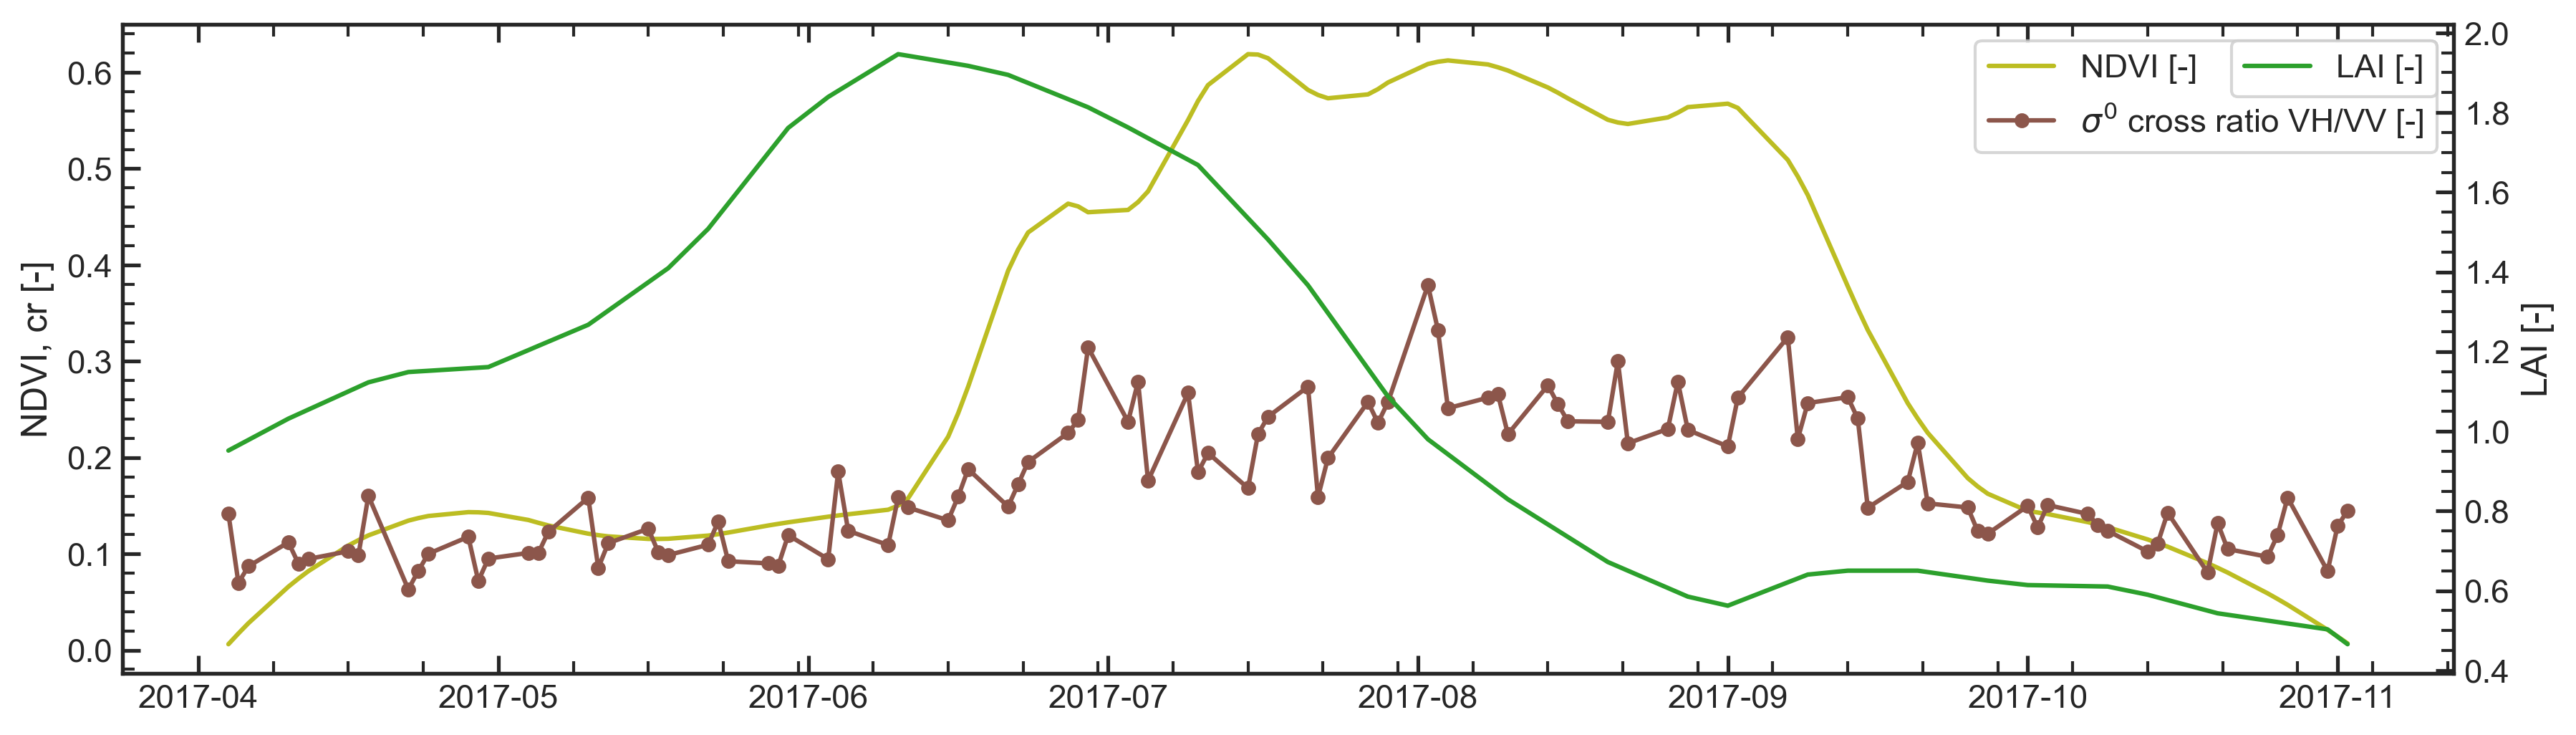

In [16]:
fig, ax = plt.subplots(1,1,figsize=(14,4),dpi=300)

ax.plot(d, NDVI, label='NDVI [-]', color='tab:olive')
ax.plot(d, cr, label=r'$\sigma^0$ cross ratio VH/VV [-]',
               marker='o', markersize=4,
               color='tab:brown')
plt.legend(loc='upper right')
plt.ylabel('NDVI, cr [-]')

ax4=ax.twinx()
ax4.plot(d, LAI, label='LAI [-]', color='tab:green')
ax4.set_ylabel('LAI [-]')
ax4.legend(loc='best')
plt.savefig('WCM_plot_inputs_veg.png')

C:\Users\MARTINA\AppData\Local\Temp\ipykernel_872\2586598242.py:8: RuntimeWarning: invalid value encountered in sqrt
  NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
C:\Users\MARTINA\AppData\Local\Temp\ipykernel_872\2586598242.py:9: RuntimeWarning: invalid value encountered in log
  NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)


RMSE = nan
R= nan


Save cost history plot? [[]/(any)] n
Save plot? [[]/(any)] n


<Figure size 1800x1200 with 0 Axes>

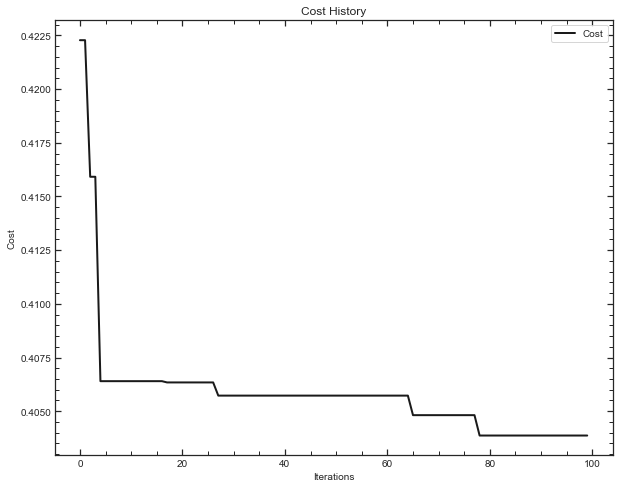

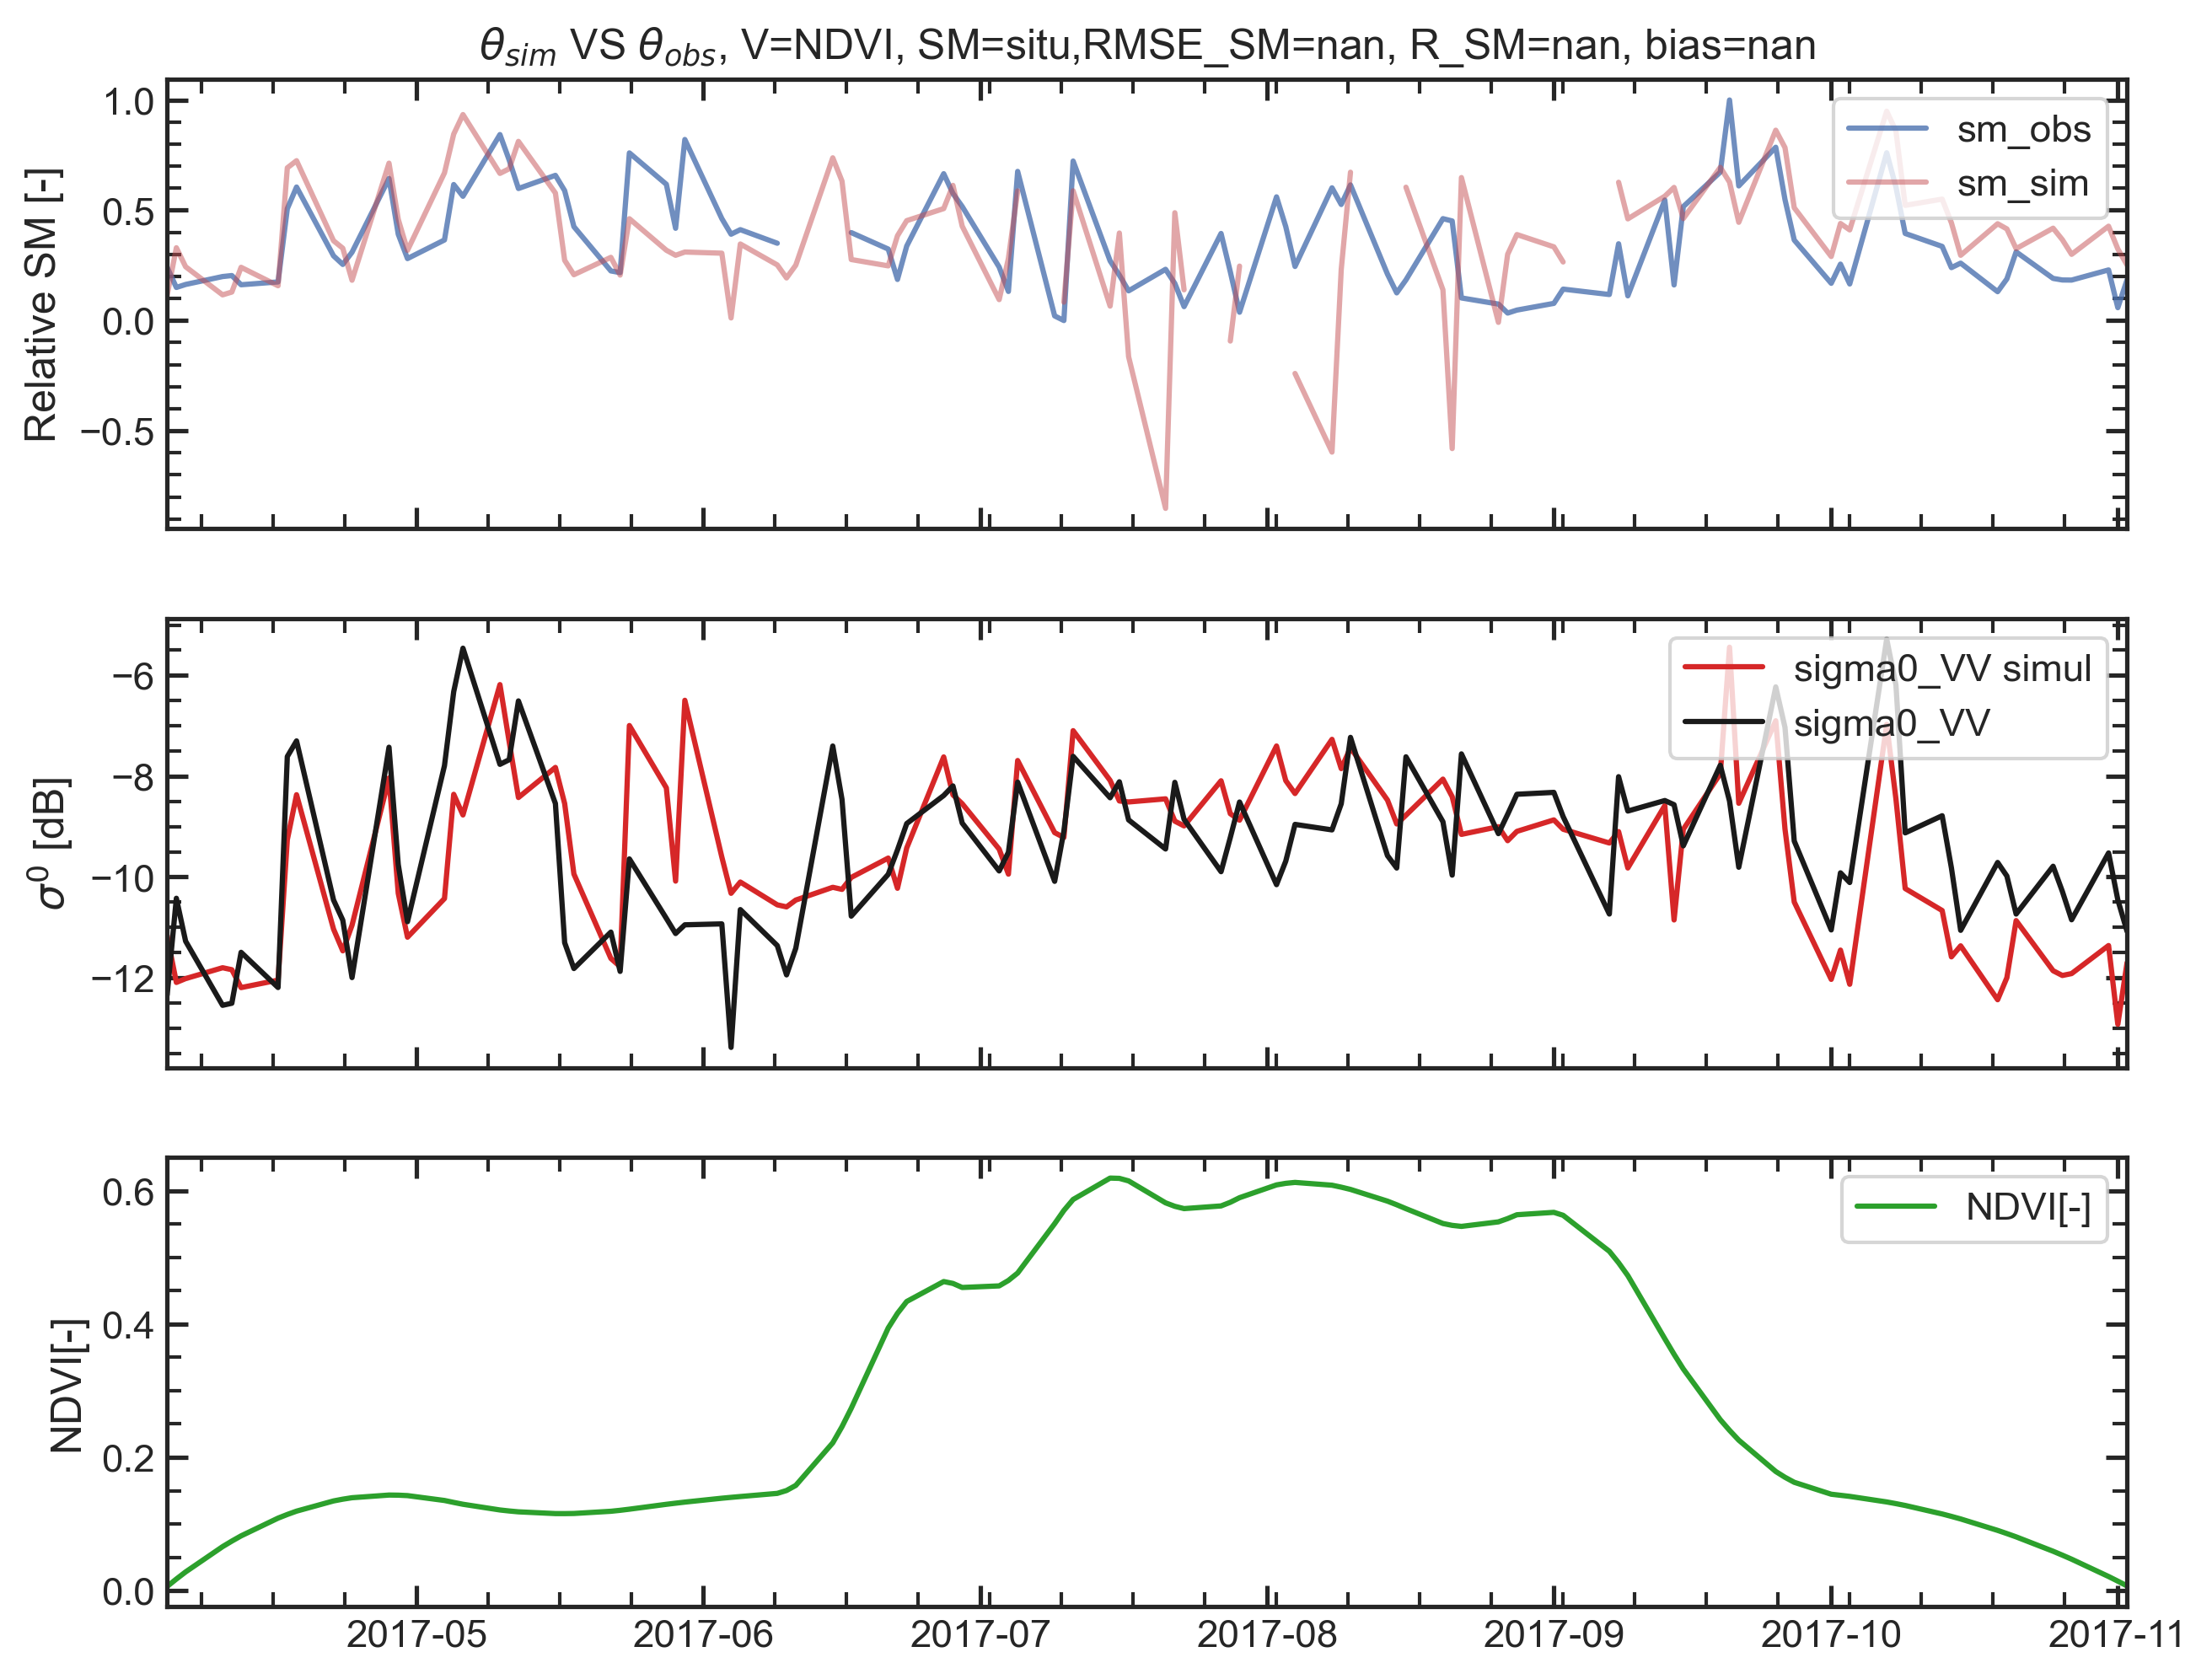

In [17]:
#-----------------------------------------------------------------------------
# Model performance
# q1 VS q2
#-----------------------------------------------------------------------------
q1 = SM
q2 = SM_retr
NS=1-np.nansum((q1-q2)**2)/np.nansum((q2-np.nanmean(q2))**2)
NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
SM_RMSE=np.mean((q1-q2)**2)**0.5; print('RMSE =', SM_RMSE)
R=np.corrcoef(q1,q2)[0][1]; print('R=', R)
biassm=bias(q1,q2)

#-----------------------------------------------------------------------------
# Optimizer performance and plot cost history
#-----------------------------------------------------------------------------
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history

plt.figure(dpi=300)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
if input('Save cost history plot? [[]/(any)]')=='':
    plt.savefig('cost_plot_WCM_v1.png')

#-----------------------------------------------------------------------------
# Timeseries
#-----------------------------------------------------------------------------
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,8),dpi=300, squeeze='squeeze')

ax[0].set_title(r'$\theta_{sim}$ VS $\theta_{obs}$'+f', V={index}, SM={soilm},'+
                f'RMSE_SM={SM_RMSE:.2f}, R_SM={R:.2f}, bias={biassm:.2f}')

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])
ax[0].plot(d, SM_gap, color='b', label='sm_obs', alpha=.8)
#if SM[10]==SM_norm[10]: ax[0].plot(d, SM_gap, color='lightblue', label='sm_obs')
ax[0].plot(d, SM_retr, color='r', label='sm_sim', alpha=.5)
#ax[0].plot(d, rt1, color='tab:orange', label='sm_rt1', alpha=.5)

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(d, sigma0_retr, label='sigma0_VV simul', color='tab:red')
ax[1].plot(d, obs, label='sigma0_VV', color='k')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$\sigma^0$ [dB]')

ax[2].plot(d, veg, label=label_veg, color='tab:green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel(label_veg)

if input('Save plot? [[]/(any)]')=='':
    plt.savefig('WCM.png')

C:\Users\MARTINA\AppData\Local\Temp\ipykernel_872\3648236341.py:10: RuntimeWarning: invalid value encountered in sqrt
  NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
C:\Users\MARTINA\AppData\Local\Temp\ipykernel_872\3648236341.py:11: RuntimeWarning: invalid value encountered in log
  NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)


RMSE = nan
R= nan


Save cost history plot? [[]/(any)] n
Save plot? [[]/(any)] n


<Figure size 1800x1200 with 0 Axes>

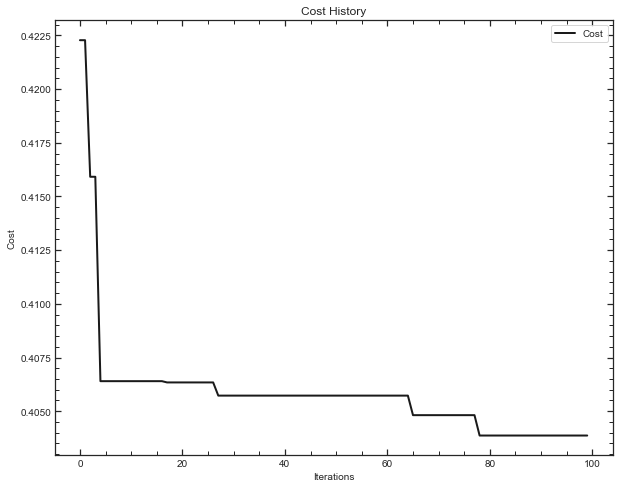

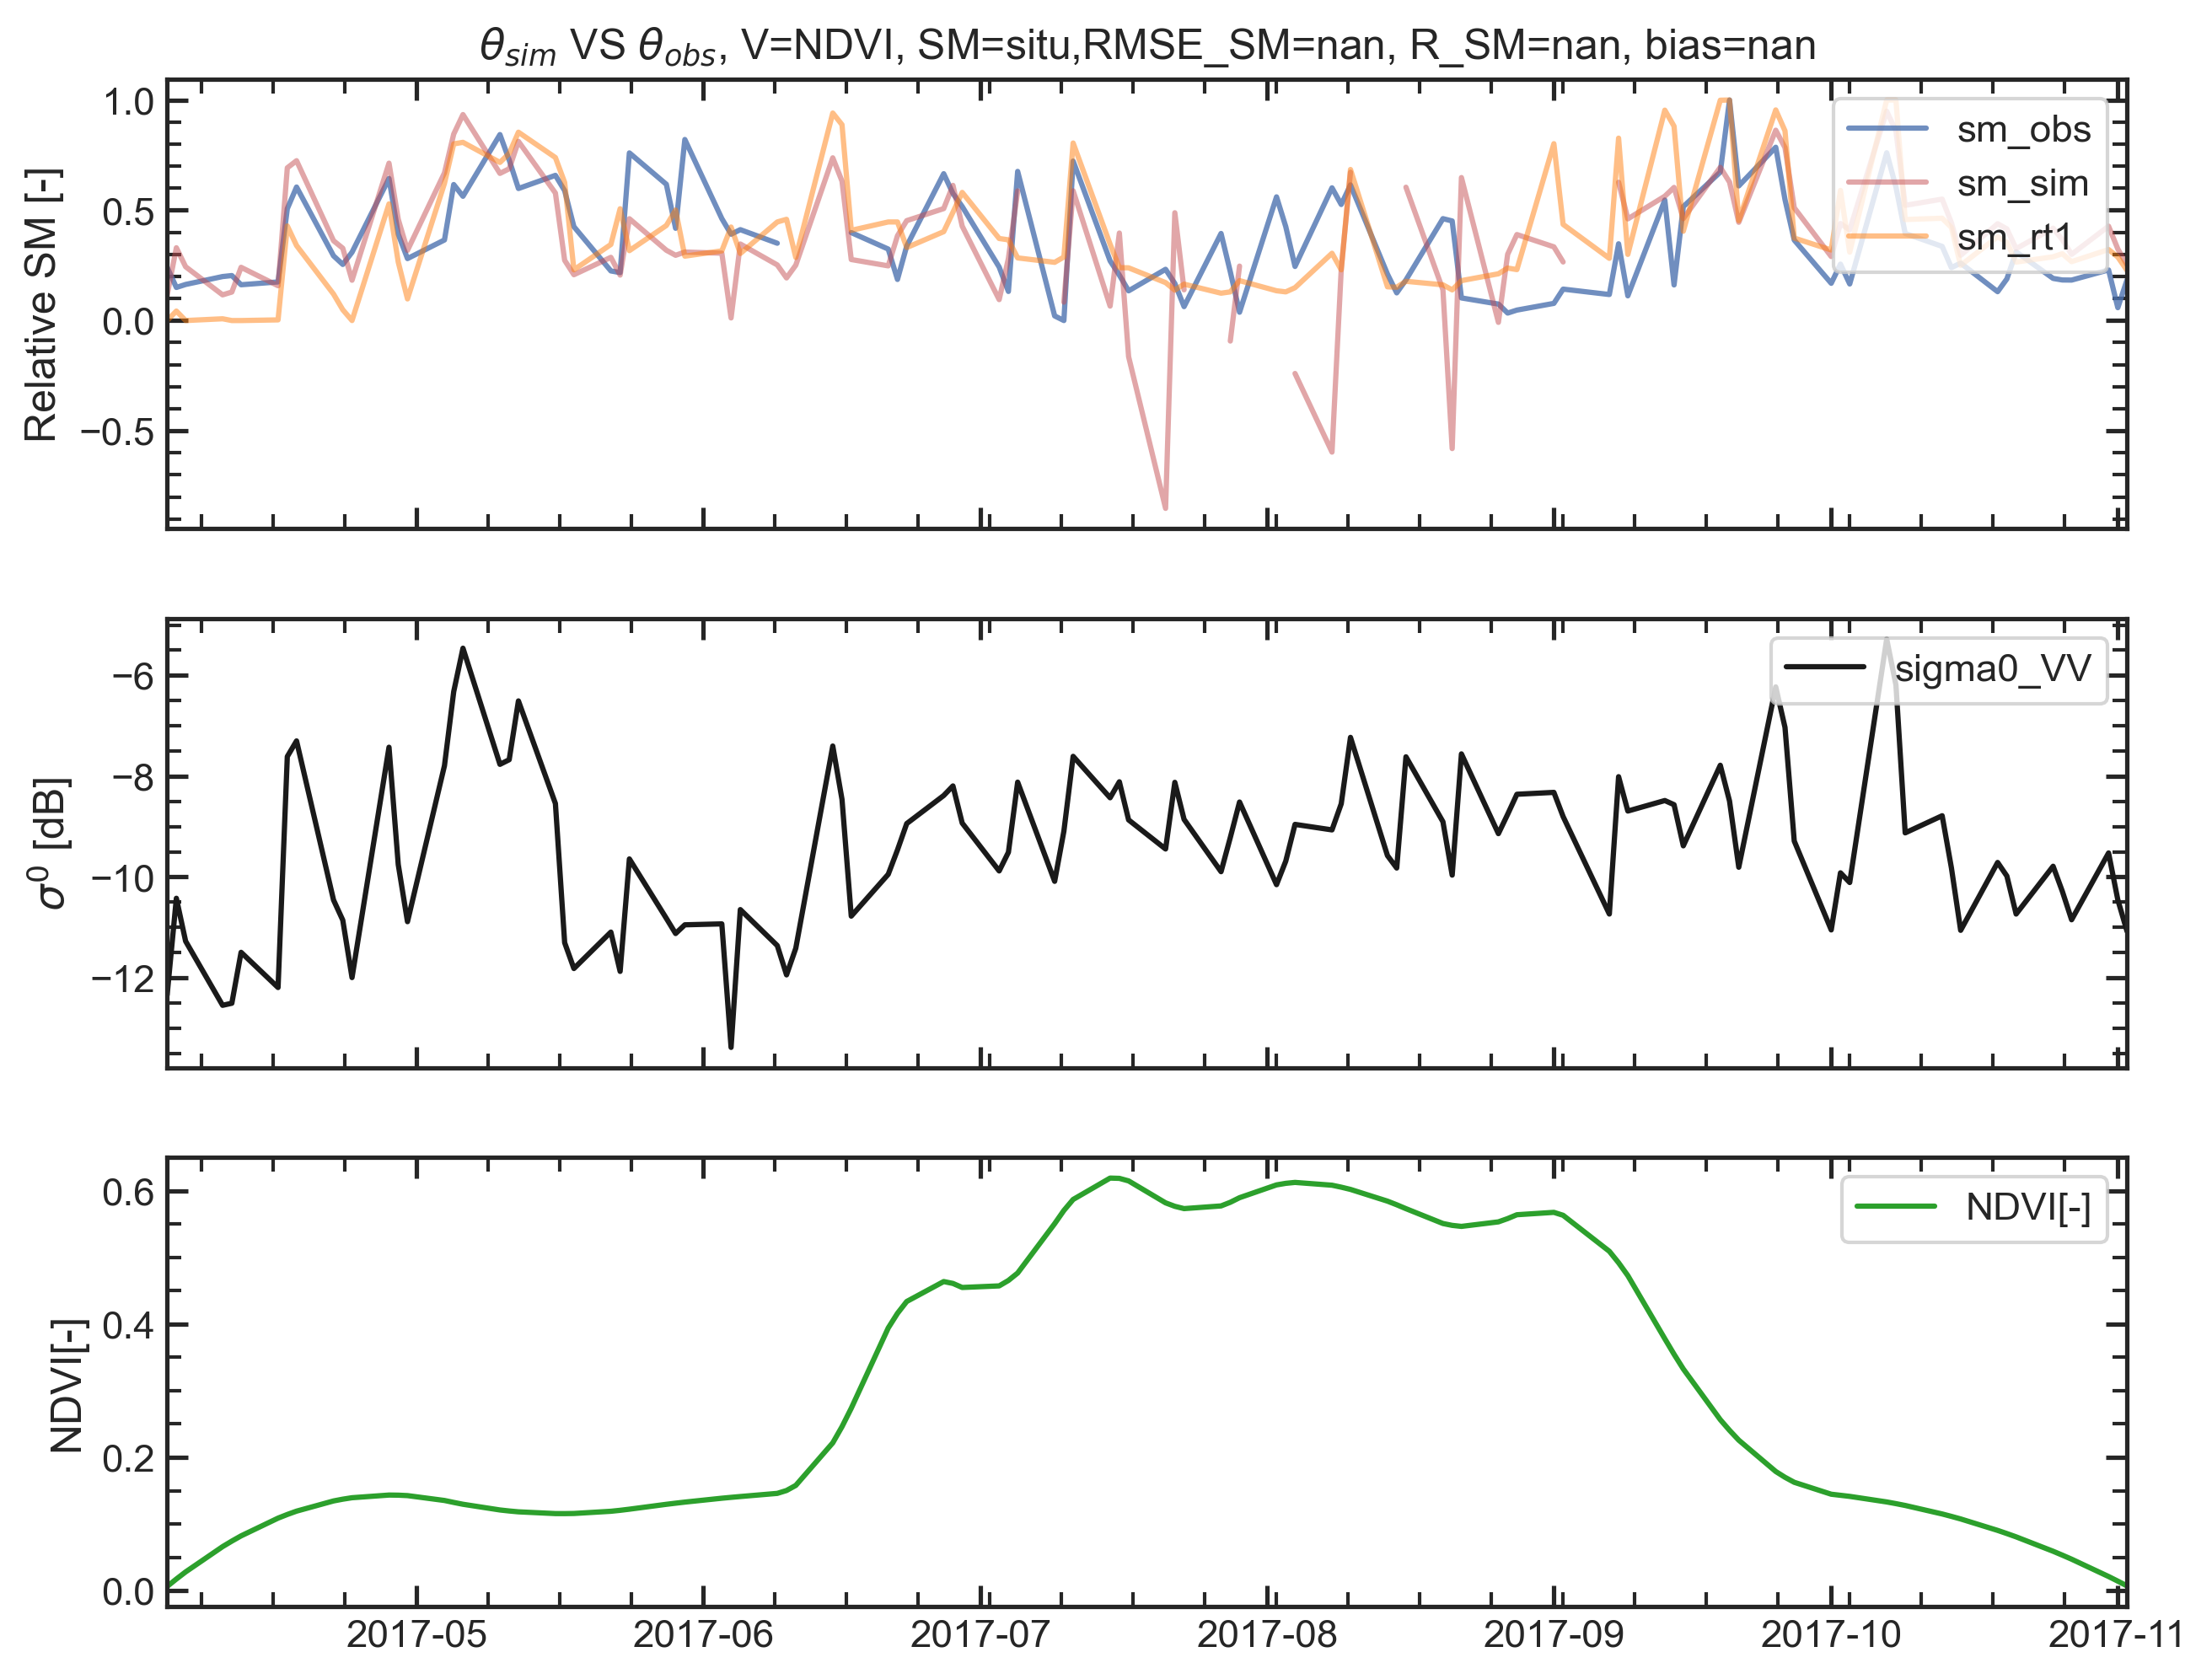

In [18]:
#-----------------------------------------------------------------------------
# Sigma0
#-----------------------------------------------------------------------------
# Model performance
# q1 VS q2
#-----------------------------------------------------------------------------
q1 = SM_norm
q2 = SM_retr
NS=1-np.nansum((q1-q2)**2)/np.nansum((q2-np.nanmean(q2))**2)
NS_radQ=1-np.nansum((np.sqrt(q1+0.00001)-np.sqrt(q2+0.00001))**2)/np.nansum((np.sqrt(q2+0.00001)-np.nanmean(np.sqrt(q2+0.00001)))**2)
NS_lnQ=1-np.nansum((np.log(q1+0.0001)-np.log(q2+0.0001))**2)/np.nansum((np.log(q2+0.0001)-np.nanmean(np.log(q2+0.0001)))**2)
NS_lnQ=NS_lnQ.real; # print(NS_lnQ) 
NS_radQ=NS_radQ.real; # print(NS_radQ)

# R coefficient score
SM_RMSE=np.mean((q1-q2)**2)**0.5; print('RMSE =', SM_RMSE)
R=np.corrcoef(q1,q2)[0][1]; print('R=', R)
biassm=bias(q1,q2)

#-----------------------------------------------------------------------------
# Optimizer performance and plot cost history
#-----------------------------------------------------------------------------
from pyswarms.utils.functions.single_obj import sphere
from pyswarms.utils.plotters import plot_cost_history

plt.figure(dpi=300)
cost_history = optimizer.cost_history
plot_cost_history(cost_history)
if input('Save cost history plot? [[]/(any)]')=='':
    plt.savefig('cost_plot_WCM_v1.png')

#-----------------------------------------------------------------------------
# Timeseries
#-----------------------------------------------------------------------------
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10,8),dpi=300, squeeze='squeeze')

ax[0].set_title(r'$\theta_{sim}$ VS $\theta_{obs}$'+f', V={index}, SM={soilm},'+
                f'RMSE_SM={SM_RMSE:.2f}, R_SM={R:.2f}, bias={biassm:.2f}')

ax[0].set_xlim(xmin=d[0], xmax=d[len(d)-1])
ax[0].plot(d, SM_gap, color='b', label='sm_obs', alpha=.8)
#if SM[10]==SM_norm[10]: ax[0].plot(d, SM_gap, color='lightblue', label='sm_obs')
ax[0].plot(d, SM_retr, color='r', label='sm_sim', alpha=.5)
ax[0].plot(d, rt1, color='tab:orange', label='sm_rt1', alpha=.5)

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Relative SM [-]')

ax[1].plot(d, obs, label='sigma0_VV', color='k')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('$\sigma^0$ [dB]')

ax[2].plot(d, veg, label=label_veg, color='tab:green')
ax[2].legend(loc='upper right')
ax[2].set_ylabel(label_veg)

if input('Save plot? [[]/(any)]')=='':
    plt.savefig('WCM.png')

ValueError: array must not contain infs or NaNs

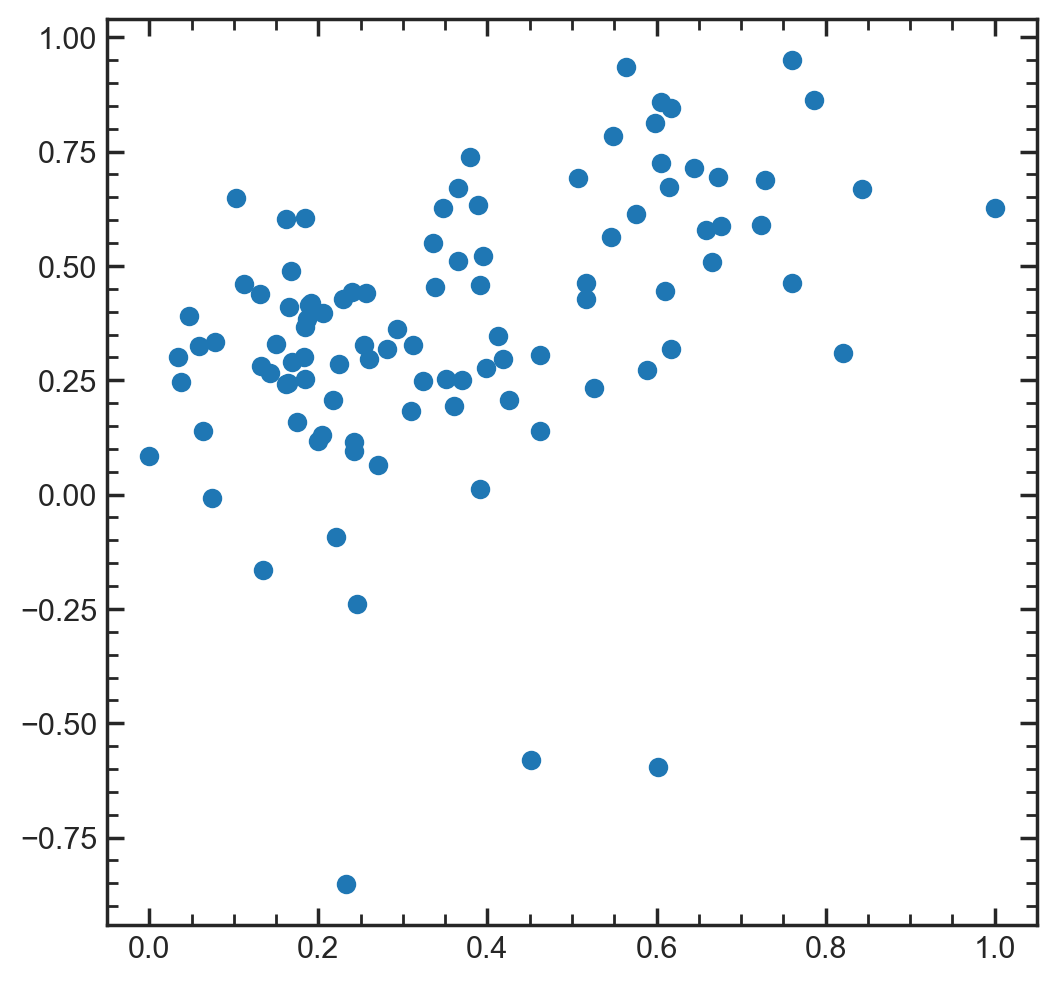

In [19]:
# Scatterplot, all period, all orbits, sm VS sigma0

x = SM_norm
y = SM_retr

plt.figure(figsize=(6,6), dpi=200)
plt.plot(x, y, marker='o', linestyle='', color='tab:blue')

# Fit
popt, pcov = curve_fit(linear, x, y)
plt.plot(x, linear(np.array(x),*popt), color='tab:orange')
R=np.corrcoef(x,y)[0][1]; print('R=', R, 'R^2=', R**2)

#plt.xlabel(r'relative soil moisture [-]'); plt.ylabel(r'$\sigma^0$')
#plt.xlim(0,1); plt.ylim(0,1)
xtext=0.8*(np.max(x)-np.min(x))+np.min(x)  ; ytext=0.1*(np.max(y)-np.min(y))+np.min(y)
t = plt.text(xtext, ytext,
             f'y={popt[0]:.2f}+{popt[1]:.2f}x\n'+
             r'$R^2$'+f'={R**2:.2f}',
             ha="center", va="center", size=15,
             bbox=dict(boxstyle="round,pad=0.3", fc="tab:orange", ec="k", lw=2, alpha=.5))

plt.title(#r'$\sigma^0$ vs relative sm - ' +
    f'R={R:.2f}, R2={R**2:.2f}')

# if save: plt.savefig(f'sim-vs-sat\\sim-vs-sat_{sat}_scatter.png')

# Snippets